In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import unidecode
from tqdm import tqdm

In [10]:
data = pd.read_csv('drom.csv',index_col=[0])

In [11]:
data.head()

,Цена,Город,Модель,Год,Коробка передач,Привод,Тип кузова,Цвет,"Пробег, км",Руль,Особые отметки,Поколение,Комплектация,Пробег
0,915000,Якутск,Toyota Allion,2011,вариатор,4WD,NaN,серый,130 000,правый,NaN,"2 поколение, рестайлинг",1.8 A18 G package luxury edition 4WD,NaN
1,599000,Владивосток,Toyota Allion,2007,вариатор,передний,NaN,голубой,150 000,правый,NaN,2 поколение,1.8 A18 S package,NaN
2,680000,Находка,Toyota Allion,2007,вариатор,передний,NaN,зеленый,235 000,правый,NaN,2 поколение,NaN,NaN
3,777777,Большой Камень,Toyota Allion,2008,вариатор,передний,NaN,черный,156 270,правый,NaN,2 поколение,1.8 A18 S package,NaN
4,750000,Иркутск,Toyota Allion,2007,вариатор,передний,NaN,зеленый,199 000,правый,NaN,2 поколение,1.8 A18,NaN


In [12]:
data.dtypes

Цена                int64
Город              object
Модель             object
Год                 int64
Коробка передач    object
Привод             object
Тип кузова         object
Цвет               object
Пробег, км         object
Руль               object
Особые отметки     object
Поколение          object
Комплектация       object
Пробег             object
dtype: object

Цена - 0%
Город - 0%
Модель - 0%
Год - 0%
Коробка передач - 2%
Привод - 1%
Тип кузова - 52%
Цвет - 4%
Пробег, км - 14%
Руль - 6%
Особые отметки - 97%
Поколение - 4%
Комплектация - 42%
Пробег - 87%


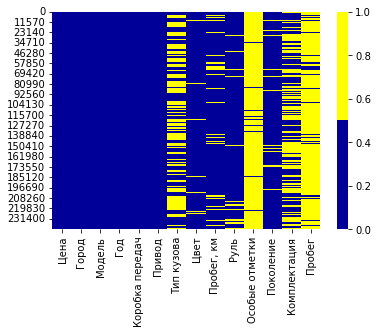

In [13]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))

for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

In [14]:
#Составим список признаков, у которых более 95% строк содержат одно и то же значение.

num_rows = len(data.index)
low_information_cols = [] #

for col in data.columns:
    cnts = data[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

Особые отметки: 96.73351%
NaN                                                                                       235016
требуется ремонт или не на ходу                                                             5603
документы с проблемами или отсутствуют                                                       993
требуется ремонт или не на ходу, документы с проблемами или отсутствуют                      143
документы с проблемами, конструктор                                                           32
                                                                                           ...  
документы с проблемами, учёт КZ                                                                1
документы с проблемами, неоформленный конструктор                                              1
документы с проблемами, конструктор, грузовая таможенная декларация                            1
документы с проблемами, учет Казахстан                                                         1
доку

In [15]:
###Baseline

In [16]:
def catboost(data):
    cat_feat = data.select_dtypes(include=['object']).columns.tolist()
    y = data['Цена']
    X = data.drop('Цена', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    model = CatBoostRegressor(cat_features=cat_feat, iterations=2000)
    
    model.fit(X_train, y_train)
    
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    return model, mae_train, mae_test

In [27]:
model, mae_train, mae_test = catboost(data.fillna('неизвестно'))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.052104
0:	learn: 1595030.7902032	total: 556ms	remaining: 18m 31s
1:	learn: 1543312.3664534	total: 788ms	remaining: 13m 7s
2:	learn: 1494203.4837567	total: 1.21s	remaining: 13m 27s
3:	learn: 1448269.4561327	total: 1.66s	remaining: 13m 49s
4:	learn: 1404312.1570446	total: 2.09s	remaining: 13m 55s
5:	learn: 1364451.3514500	total: 2.59s	remaining: 14m 22s
6:	learn: 1326867.1707610	total: 2.96s	remaining: 14m 3s
7:	learn: 1291533.8400188	total: 3.36s	remaining: 13m 57s
8:	learn: 1258945.7374870	total: 3.76s	remaining: 13m 51s
9:	learn: 1225872.7400884	total: 4.24s	remaining: 14m 3s
10:	learn: 1197311.9629208	total: 4.63s	remaining: 13m 57s
11:	learn: 1167746.6195002	total: 5.06s	remaining: 13m 58s
12:	learn: 1139633.0581635	total: 5.47s	remaining: 13m 56s
13:	learn: 1115331.2311173	total: 5.9s	remaining: 13m 56s
14:	learn: 1089965.7802289	total: 6.43s	remaining: 14m 11s
15:	learn: 1068095.6789250	total: 7.03s	remaining: 14m 31s
16:	learn: 1048862.0407166	total: 7.65s	

141:	learn: 589723.9198654	total: 1m	remaining: 13m 7s
142:	learn: 589371.8935667	total: 1m	remaining: 13m 6s
143:	learn: 588474.7130514	total: 1m	remaining: 13m 4s
144:	learn: 587599.4753411	total: 1m 1s	remaining: 13m 2s
145:	learn: 586133.7182083	total: 1m 1s	remaining: 13m 1s
146:	learn: 584495.3811494	total: 1m 1s	remaining: 13m 1s
147:	learn: 583343.5615669	total: 1m 2s	remaining: 13m
148:	learn: 582955.3504946	total: 1m 2s	remaining: 12m 59s
149:	learn: 581615.3644007	total: 1m 3s	remaining: 12m 58s
150:	learn: 580859.5551721	total: 1m 3s	remaining: 12m 57s
151:	learn: 579962.2689617	total: 1m 3s	remaining: 12m 56s
152:	learn: 578851.7625418	total: 1m 4s	remaining: 12m 55s
153:	learn: 578238.2587633	total: 1m 4s	remaining: 12m 55s
154:	learn: 577947.9027903	total: 1m 5s	remaining: 12m 54s
155:	learn: 577371.8140065	total: 1m 5s	remaining: 12m 53s
156:	learn: 576527.1872262	total: 1m 5s	remaining: 12m 53s
157:	learn: 575826.3626179	total: 1m 6s	remaining: 12m 52s
158:	learn: 5747

279:	learn: 520892.8943440	total: 1m 57s	remaining: 12m 3s
280:	learn: 520576.5602091	total: 1m 58s	remaining: 12m 2s
281:	learn: 520573.2136882	total: 1m 58s	remaining: 12m 2s
282:	learn: 520428.2334166	total: 1m 58s	remaining: 12m 1s
283:	learn: 520423.7863754	total: 1m 59s	remaining: 12m 1s
284:	learn: 520418.9024393	total: 1m 59s	remaining: 12m
285:	learn: 520204.5493310	total: 2m	remaining: 12m
286:	learn: 519882.2181549	total: 2m	remaining: 11m 59s
287:	learn: 519878.2492943	total: 2m 1s	remaining: 12m
288:	learn: 519525.2310227	total: 2m 1s	remaining: 12m
289:	learn: 518701.6450912	total: 2m 2s	remaining: 12m
290:	learn: 518337.4611791	total: 2m 2s	remaining: 11m 59s
291:	learn: 518237.5945458	total: 2m 3s	remaining: 11m 59s
292:	learn: 517867.4077362	total: 2m 3s	remaining: 11m 59s
293:	learn: 517622.2656710	total: 2m 3s	remaining: 11m 58s
294:	learn: 517619.4719272	total: 2m 4s	remaining: 11m 58s
295:	learn: 517295.3552000	total: 2m 4s	remaining: 11m 58s
296:	learn: 516889.035

417:	learn: 480140.9154694	total: 2m 57s	remaining: 11m 13s
418:	learn: 479943.5965661	total: 2m 58s	remaining: 11m 13s
419:	learn: 479750.3547080	total: 2m 58s	remaining: 11m 12s
420:	learn: 476776.2681011	total: 2m 59s	remaining: 11m 12s
421:	learn: 476708.9444903	total: 2m 59s	remaining: 11m 11s
422:	learn: 476214.8307403	total: 3m	remaining: 11m 11s
423:	learn: 475743.3940387	total: 3m	remaining: 11m 11s
424:	learn: 475572.9582449	total: 3m	remaining: 11m 10s
425:	learn: 475085.0054284	total: 3m 1s	remaining: 11m 9s
426:	learn: 474898.8370316	total: 3m 1s	remaining: 11m 8s
427:	learn: 474712.8594336	total: 3m 1s	remaining: 11m 7s
428:	learn: 473389.5288680	total: 3m 2s	remaining: 11m 7s
429:	learn: 473098.6256621	total: 3m 2s	remaining: 11m 7s
430:	learn: 472457.7307912	total: 3m 3s	remaining: 11m 6s
431:	learn: 472307.2023128	total: 3m 3s	remaining: 11m 6s
432:	learn: 472252.2268427	total: 3m 4s	remaining: 11m 6s
433:	learn: 472008.9811236	total: 3m 4s	remaining: 11m 5s
434:	learn

555:	learn: 448941.6629788	total: 3m 56s	remaining: 10m 14s
556:	learn: 448931.9227511	total: 3m 56s	remaining: 10m 13s
557:	learn: 448704.3258293	total: 3m 57s	remaining: 10m 13s
558:	learn: 448434.0197294	total: 3m 57s	remaining: 10m 12s
559:	learn: 448263.6018705	total: 3m 58s	remaining: 10m 12s
560:	learn: 448050.7064793	total: 3m 58s	remaining: 10m 12s
561:	learn: 447843.2085380	total: 3m 59s	remaining: 10m 11s
562:	learn: 447700.8156689	total: 3m 59s	remaining: 10m 10s
563:	learn: 447443.3097956	total: 3m 59s	remaining: 10m 9s
564:	learn: 447437.4643471	total: 3m 59s	remaining: 10m 9s
565:	learn: 447207.3099314	total: 4m	remaining: 10m 9s
566:	learn: 447181.6452926	total: 4m	remaining: 10m 8s
567:	learn: 447118.9995396	total: 4m 1s	remaining: 10m 8s
568:	learn: 447094.9616979	total: 4m 1s	remaining: 10m 7s
569:	learn: 446768.6588093	total: 4m 2s	remaining: 10m 7s
570:	learn: 446519.1298507	total: 4m 2s	remaining: 10m 7s
571:	learn: 446389.6074713	total: 4m 2s	remaining: 10m 6s
57

695:	learn: 424089.3257947	total: 4m 57s	remaining: 9m 17s
696:	learn: 424068.0138128	total: 4m 57s	remaining: 9m 16s
697:	learn: 423955.5176924	total: 4m 58s	remaining: 9m 16s
698:	learn: 423408.1057265	total: 4m 58s	remaining: 9m 15s
699:	learn: 423301.5841743	total: 4m 59s	remaining: 9m 15s
700:	learn: 422821.4034530	total: 4m 59s	remaining: 9m 15s
701:	learn: 422717.2685597	total: 5m	remaining: 9m 14s
702:	learn: 422611.4515976	total: 5m	remaining: 9m 14s
703:	learn: 422301.8700927	total: 5m	remaining: 9m 13s
704:	learn: 422017.0872456	total: 5m 1s	remaining: 9m 13s
705:	learn: 421803.7145590	total: 5m 1s	remaining: 9m 12s
706:	learn: 421336.0144218	total: 5m 2s	remaining: 9m 12s
707:	learn: 421264.4227784	total: 5m 2s	remaining: 9m 11s
708:	learn: 421165.4383993	total: 5m 2s	remaining: 9m 11s
709:	learn: 420922.6110418	total: 5m 3s	remaining: 9m 11s
710:	learn: 420900.3683909	total: 5m 3s	remaining: 9m 10s
711:	learn: 420773.5416118	total: 5m 4s	remaining: 9m 10s
712:	learn: 42064

835:	learn: 406324.1001478	total: 5m 58s	remaining: 8m 18s
836:	learn: 406290.3343239	total: 5m 58s	remaining: 8m 17s
837:	learn: 406196.3797318	total: 5m 58s	remaining: 8m 17s
838:	learn: 406145.0617399	total: 5m 59s	remaining: 8m 16s
839:	learn: 406129.7838745	total: 5m 59s	remaining: 8m 16s
840:	learn: 406103.9617334	total: 5m 59s	remaining: 8m 15s
841:	learn: 406076.0838968	total: 6m	remaining: 8m 15s
842:	learn: 406045.4904642	total: 6m	remaining: 8m 14s
843:	learn: 405996.3980830	total: 6m 1s	remaining: 8m 14s
844:	learn: 405882.4069699	total: 6m 1s	remaining: 8m 13s
845:	learn: 405697.5108910	total: 6m 2s	remaining: 8m 13s
846:	learn: 405577.5550630	total: 6m 2s	remaining: 8m 13s
847:	learn: 405544.7013536	total: 6m 2s	remaining: 8m 12s
848:	learn: 405541.0182996	total: 6m 3s	remaining: 8m 12s
849:	learn: 405325.7975591	total: 6m 3s	remaining: 8m 12s
850:	learn: 405313.9202244	total: 6m 4s	remaining: 8m 11s
851:	learn: 405241.1129348	total: 6m 4s	remaining: 8m 11s
852:	learn: 40

975:	learn: 393491.6180401	total: 6m 58s	remaining: 7m 19s
976:	learn: 393356.4261683	total: 6m 59s	remaining: 7m 18s
977:	learn: 393271.7226384	total: 6m 59s	remaining: 7m 18s
978:	learn: 393148.5835152	total: 7m	remaining: 7m 18s
979:	learn: 393045.4318421	total: 7m	remaining: 7m 17s
980:	learn: 393044.3742096	total: 7m	remaining: 7m 17s
981:	learn: 392744.8414029	total: 7m 1s	remaining: 7m 16s
982:	learn: 392640.9844667	total: 7m 1s	remaining: 7m 16s
983:	learn: 392558.9905166	total: 7m 2s	remaining: 7m 16s
984:	learn: 392529.7817100	total: 7m 2s	remaining: 7m 15s
985:	learn: 392355.0924232	total: 7m 3s	remaining: 7m 15s
986:	learn: 392300.9418101	total: 7m 3s	remaining: 7m 14s
987:	learn: 391475.0385224	total: 7m 4s	remaining: 7m 14s
988:	learn: 391424.1518668	total: 7m 4s	remaining: 7m 13s
989:	learn: 391398.5777952	total: 7m 4s	remaining: 7m 13s
990:	learn: 391385.0916322	total: 7m 5s	remaining: 7m 12s
991:	learn: 391339.3337349	total: 7m 5s	remaining: 7m 12s
992:	learn: 391161.7

1114:	learn: 379172.0122140	total: 8m 3s	remaining: 6m 23s
1115:	learn: 378633.2628882	total: 8m 3s	remaining: 6m 23s
1116:	learn: 378573.9312179	total: 8m 4s	remaining: 6m 22s
1117:	learn: 378378.8875943	total: 8m 4s	remaining: 6m 22s
1118:	learn: 378318.8559292	total: 8m 5s	remaining: 6m 21s
1119:	learn: 378290.1942109	total: 8m 5s	remaining: 6m 21s
1120:	learn: 378282.1112303	total: 8m 6s	remaining: 6m 21s
1121:	learn: 378182.4462258	total: 8m 6s	remaining: 6m 20s
1122:	learn: 378131.1616142	total: 8m 7s	remaining: 6m 20s
1123:	learn: 378123.7979091	total: 8m 7s	remaining: 6m 19s
1124:	learn: 378053.3489426	total: 8m 7s	remaining: 6m 19s
1125:	learn: 378038.1784041	total: 8m 8s	remaining: 6m 19s
1126:	learn: 377974.4598514	total: 8m 8s	remaining: 6m 18s
1127:	learn: 377913.1031921	total: 8m 9s	remaining: 6m 18s
1128:	learn: 377910.6779834	total: 8m 9s	remaining: 6m 17s
1129:	learn: 377909.4645105	total: 8m 10s	remaining: 6m 17s
1130:	learn: 377877.1744245	total: 8m 10s	remaining: 6m

1252:	learn: 370905.3874462	total: 9m 5s	remaining: 5m 25s
1253:	learn: 370876.0665471	total: 9m 5s	remaining: 5m 24s
1254:	learn: 370483.0133303	total: 9m 6s	remaining: 5m 24s
1255:	learn: 370434.6665609	total: 9m 6s	remaining: 5m 23s
1256:	learn: 370397.0558454	total: 9m 7s	remaining: 5m 23s
1257:	learn: 370345.3369060	total: 9m 7s	remaining: 5m 23s
1258:	learn: 370340.0629950	total: 9m 8s	remaining: 5m 22s
1259:	learn: 370335.2451072	total: 9m 8s	remaining: 5m 22s
1260:	learn: 370289.4700781	total: 9m 8s	remaining: 5m 21s
1261:	learn: 370266.3504079	total: 9m 9s	remaining: 5m 21s
1262:	learn: 370237.8697868	total: 9m 9s	remaining: 5m 20s
1263:	learn: 370196.9395432	total: 9m 10s	remaining: 5m 20s
1264:	learn: 370191.6676948	total: 9m 10s	remaining: 5m 19s
1265:	learn: 370139.3668983	total: 9m 11s	remaining: 5m 19s
1266:	learn: 370129.9349940	total: 9m 11s	remaining: 5m 19s
1267:	learn: 370094.0719736	total: 9m 11s	remaining: 5m 18s
1268:	learn: 370056.4093087	total: 9m 12s	remaining

1390:	learn: 361810.4577871	total: 10m 11s	remaining: 4m 27s
1391:	learn: 361750.4108155	total: 10m 11s	remaining: 4m 27s
1392:	learn: 361693.1444711	total: 10m 11s	remaining: 4m 26s
1393:	learn: 361548.0970870	total: 10m 12s	remaining: 4m 26s
1394:	learn: 361325.8938413	total: 10m 13s	remaining: 4m 25s
1395:	learn: 361291.8830991	total: 10m 13s	remaining: 4m 25s
1396:	learn: 361242.1991833	total: 10m 13s	remaining: 4m 25s
1397:	learn: 361120.4422375	total: 10m 14s	remaining: 4m 24s
1398:	learn: 360892.9275122	total: 10m 14s	remaining: 4m 24s
1399:	learn: 360864.0781673	total: 10m 15s	remaining: 4m 23s
1400:	learn: 360848.3498859	total: 10m 15s	remaining: 4m 23s
1401:	learn: 360787.9321517	total: 10m 15s	remaining: 4m 22s
1402:	learn: 360647.2388935	total: 10m 16s	remaining: 4m 22s
1403:	learn: 360636.9173983	total: 10m 16s	remaining: 4m 21s
1404:	learn: 360509.4869389	total: 10m 17s	remaining: 4m 21s
1405:	learn: 360461.1651664	total: 10m 17s	remaining: 4m 20s
1406:	learn: 360430.9939

1526:	learn: 352932.4583362	total: 11m 11s	remaining: 3m 28s
1527:	learn: 352925.1054902	total: 11m 12s	remaining: 3m 27s
1528:	learn: 352924.2089723	total: 11m 12s	remaining: 3m 27s
1529:	learn: 352922.7246451	total: 11m 12s	remaining: 3m 26s
1530:	learn: 352897.7583618	total: 11m 13s	remaining: 3m 26s
1531:	learn: 352830.4976150	total: 11m 13s	remaining: 3m 25s
1532:	learn: 352795.6172318	total: 11m 14s	remaining: 3m 25s
1533:	learn: 352716.8004633	total: 11m 14s	remaining: 3m 24s
1534:	learn: 352676.5168581	total: 11m 15s	remaining: 3m 24s
1535:	learn: 352651.4726789	total: 11m 15s	remaining: 3m 24s
1536:	learn: 352647.6688783	total: 11m 16s	remaining: 3m 23s
1537:	learn: 352591.1562436	total: 11m 16s	remaining: 3m 23s
1538:	learn: 352545.7919001	total: 11m 17s	remaining: 3m 22s
1539:	learn: 352544.3705746	total: 11m 17s	remaining: 3m 22s
1540:	learn: 352543.0562971	total: 11m 17s	remaining: 3m 21s
1541:	learn: 352528.5400971	total: 11m 18s	remaining: 3m 21s
1542:	learn: 352456.2179

1663:	learn: 346555.3196762	total: 12m 22s	remaining: 2m 29s
1664:	learn: 346507.5624604	total: 12m 22s	remaining: 2m 29s
1665:	learn: 346486.9166872	total: 12m 22s	remaining: 2m 28s
1666:	learn: 346476.2118175	total: 12m 23s	remaining: 2m 28s
1667:	learn: 346465.8812438	total: 12m 23s	remaining: 2m 27s
1668:	learn: 346448.3301622	total: 12m 24s	remaining: 2m 27s
1669:	learn: 346442.8292828	total: 12m 24s	remaining: 2m 27s
1670:	learn: 346397.4815824	total: 12m 25s	remaining: 2m 26s
1671:	learn: 346396.5463401	total: 12m 25s	remaining: 2m 26s
1672:	learn: 346331.6145098	total: 12m 26s	remaining: 2m 25s
1673:	learn: 346319.4196005	total: 12m 26s	remaining: 2m 25s
1674:	learn: 346160.9811431	total: 12m 26s	remaining: 2m 24s
1675:	learn: 346106.7101710	total: 12m 27s	remaining: 2m 24s
1676:	learn: 345963.3658504	total: 12m 27s	remaining: 2m 24s
1677:	learn: 345956.4714112	total: 12m 28s	remaining: 2m 23s
1678:	learn: 345952.2504511	total: 12m 28s	remaining: 2m 23s
1679:	learn: 345913.1198

1799:	learn: 341145.3791386	total: 13m 28s	remaining: 1m 29s
1800:	learn: 341129.5242958	total: 13m 29s	remaining: 1m 29s
1801:	learn: 341082.9975520	total: 13m 29s	remaining: 1m 28s
1802:	learn: 340949.6543636	total: 13m 30s	remaining: 1m 28s
1803:	learn: 340927.2327943	total: 13m 30s	remaining: 1m 28s
1804:	learn: 340916.5952643	total: 13m 31s	remaining: 1m 27s
1805:	learn: 340910.7089413	total: 13m 31s	remaining: 1m 27s
1806:	learn: 340879.4046170	total: 13m 32s	remaining: 1m 26s
1807:	learn: 340802.6273201	total: 13m 33s	remaining: 1m 26s
1808:	learn: 340770.4581725	total: 13m 33s	remaining: 1m 25s
1809:	learn: 340769.7049766	total: 13m 34s	remaining: 1m 25s
1810:	learn: 340739.2036023	total: 13m 34s	remaining: 1m 25s
1811:	learn: 340674.8052474	total: 13m 35s	remaining: 1m 24s
1812:	learn: 340671.7922774	total: 13m 35s	remaining: 1m 24s
1813:	learn: 340648.0433944	total: 13m 36s	remaining: 1m 23s
1814:	learn: 340598.1426248	total: 13m 37s	remaining: 1m 23s
1815:	learn: 340550.4115

1936:	learn: 336106.9440173	total: 14m 52s	remaining: 29s
1937:	learn: 336101.5768676	total: 14m 53s	remaining: 28.6s
1938:	learn: 336092.2193528	total: 14m 53s	remaining: 28.1s
1939:	learn: 336083.7622471	total: 14m 54s	remaining: 27.7s
1940:	learn: 336076.8005159	total: 14m 54s	remaining: 27.2s
1941:	learn: 336073.1000246	total: 14m 55s	remaining: 26.7s
1942:	learn: 336004.1911149	total: 14m 56s	remaining: 26.3s
1943:	learn: 335993.6968563	total: 14m 56s	remaining: 25.8s
1944:	learn: 335985.7907784	total: 14m 57s	remaining: 25.4s
1945:	learn: 335944.4617474	total: 14m 58s	remaining: 24.9s
1946:	learn: 335918.5779472	total: 14m 59s	remaining: 24.5s
1947:	learn: 335832.8814090	total: 14m 59s	remaining: 24s
1948:	learn: 335775.4028129	total: 15m	remaining: 23.6s
1949:	learn: 335756.4085210	total: 15m 1s	remaining: 23.1s
1950:	learn: 335734.2149549	total: 15m 1s	remaining: 22.6s
1951:	learn: 335725.1045464	total: 15m 2s	remaining: 22.2s
1952:	learn: 335603.6269964	total: 15m 2s	remaining

In [ ]:
print('MAE train:',mae_train)
print('MAE test:',mae_test)

In [28]:
#####

In [17]:
data.shape

(242952, 14)

In [18]:
data.head()

,Цена,Город,Модель,Год,Коробка передач,Привод,Тип кузова,Цвет,"Пробег, км",Руль,Особые отметки,Поколение,Комплектация,Пробег
0,915000,Якутск,Toyota Allion,2011,вариатор,4WD,NaN,серый,130 000,правый,NaN,"2 поколение, рестайлинг",1.8 A18 G package luxury edition 4WD,NaN
1,599000,Владивосток,Toyota Allion,2007,вариатор,передний,NaN,голубой,150 000,правый,NaN,2 поколение,1.8 A18 S package,NaN
2,680000,Находка,Toyota Allion,2007,вариатор,передний,NaN,зеленый,235 000,правый,NaN,2 поколение,NaN,NaN
3,777777,Большой Камень,Toyota Allion,2008,вариатор,передний,NaN,черный,156 270,правый,NaN,2 поколение,1.8 A18 S package,NaN
4,750000,Иркутск,Toyota Allion,2007,вариатор,передний,NaN,зеленый,199 000,правый,NaN,2 поколение,1.8 A18,NaN


In [19]:
#Не содержатся ли в данных какие-то символы, которые могли остаться при парсинге

def find_substring(values):
    values = str(values)
    extensionsToCheck = ["[", "]", "{", "}","_"]
    if any(ext in values for ext in extensionsToCheck):
        return True
    else:
        return False
    
for column in data.columns:
    print("{}, плохих значений {}".format(column,data[column].apply(find_substring).sum()))

Цена, плохих значений 0
Город, плохих значений 0
Модель, плохих значений 0
Год, плохих значений 0
Коробка передач, плохих значений 0
Привод, плохих значений 0
Тип кузова, плохих значений 0
Цвет, плохих значений 0
Пробег, км, плохих значений 0
Руль, плохих значений 0
Особые отметки, плохих значений 0
Поколение, плохих значений 0
Комплектация, плохих значений 0
Пробег, плохих значений 0


In [20]:
cat_feat = data.select_dtypes(include=['object']).columns.tolist()
for i in cat_feat:
    print("{}, уникальных значений {}".format(i, data[i].nunique()))

Город, уникальных значений 2384
Модель, уникальных значений 351
Коробка передач, уникальных значений 5
Привод, уникальных значений 3
Тип кузова, уникальных значений 11
Цвет, уникальных значений 16
Пробег, км, уникальных значений 46639
Руль, уникальных значений 2
Особые отметки, уникальных значений 850
Поколение, уникальных значений 50
Комплектация, уникальных значений 11688
Пробег, уникальных значений 1


In [21]:
def generation(values):
    try:
        string_list = values.split(' ')
        return string_list[0]
    except:
        return -1
    
def restyling(values):
    find_subst='рестайлинг'
    try:
        string_list = values.split(' ')
        if find_subst in string_list:
            return 1
        else:
            return 0
    except:
        return -1
    
data['Поколение'] = data['Поколение'].apply(generation)
data['Рестайлинг'] = data['Поколение'].apply(restyling)

In [22]:
data['Проблема с документами'] = data['Особые отметки'].apply(lambda x: 1 if str(x) in 'документы' else 0)
data['Ремонт'] = data['Особые отметки'].apply(lambda x: 1 if str(x) in ['ремонт','не на ходу'] else 0)

In [23]:
def body_type(values):        
    try:
        string_list = values.split(' ')
        if '/' in string:
            return string.split('/')[0]
        else:
            return string_list[0]
    except:
        if isinstance(values, float):
            return 'неизвестно'
        else:
            values
            
data['Тип кузова'] = data['Тип кузова'].apply(body_type)

In [24]:
data['Пробег, км'] = data['Пробег, км'].fillna(0)
data['Новый автомобиль'] = data['Пробег'].apply(lambda x: 1 if str(x) in 'новый автомобиль' else 0)

In [25]:
data = data.drop(['Пробег','Особые отметки','Пробег'], axis=1)
data['Комплектация'] = data['Комплектация'].fillna('unknown')

In [26]:
data[['Коробка передач','Привод','Тип кузова','Цвет','Руль']] = data[['Коробка передач','Привод','Тип кузова','Цвет','Руль']].fillna('неизвестно')

In [27]:
def mileage_russia(values):
    try:
        string_list = values.split(',')
        if 'б/п по РФ' in string_list:
            return 1
        else:
            return 0
    except:
        return 0

data['Пробег по РФ'] = data['Пробег, км'].apply(mileage_russia)  

In [28]:
def unicode_to_int(values):
    values = unidecode.unidecode(values)
    values = values.replace(' ','')
    return int(values)

def milliage(values):
    try:
        values = unicode_to_int(values)
        return values
    except:
        try:
            string_list = values.split(',')
            if 'б/п по РФ' in string_list and len(string_list)==1:
                return 0
            else:
                return unicode_to_int(string_list[0])
        except:
            return int(values)
        
     
data['Пробег, км'] = data['Пробег, км'].apply(milliage)
data['Пробег, км'] = data['Пробег, км'].astype('int')
data['Поколение'] = data['Поколение'].astype('int')

In [29]:
data.dtypes

Цена                       int64
Город                     object
Модель                    object
Год                        int64
Коробка передач           object
Привод                    object
Тип кузова                object
Цвет                      object
Пробег, км                 int32
Руль                      object
Поколение                  int32
Комплектация              object
Рестайлинг                 int64
Проблема с документами     int64
Ремонт                     int64
Новый автомобиль           int64
Пробег по РФ               int64
dtype: object

In [42]:
model, mae_train, mae_test = catboost(data)

Learning rate set to 0.052104
0:	learn: 1597038.4758087	total: 480ms	remaining: 15m 58s
1:	learn: 1545811.3453820	total: 870ms	remaining: 14m 29s
2:	learn: 1497494.7475826	total: 1.25s	remaining: 13m 54s
3:	learn: 1451261.1130360	total: 1.64s	remaining: 13m 38s
4:	learn: 1408038.5154979	total: 2.03s	remaining: 13m 31s
5:	learn: 1368354.3051222	total: 2.4s	remaining: 13m 16s
6:	learn: 1331700.1873641	total: 2.59s	remaining: 12m 17s
7:	learn: 1296683.1388400	total: 2.8s	remaining: 11m 38s
8:	learn: 1263278.1803802	total: 3.13s	remaining: 11m 31s
9:	learn: 1231946.1924874	total: 3.3s	remaining: 10m 56s
10:	learn: 1201407.8637571	total: 3.62s	remaining: 10m 54s
11:	learn: 1173287.9413754	total: 3.93s	remaining: 10m 50s
12:	learn: 1146210.0868882	total: 4.21s	remaining: 10m 44s
13:	learn: 1121542.2268469	total: 4.51s	remaining: 10m 39s
14:	learn: 1099667.0925338	total: 4.8s	remaining: 10m 35s
15:	learn: 1074407.9157194	total: 5.14s	remaining: 10m 37s
16:	learn: 1051159.6805437	total: 5.32s	

141:	learn: 581019.4718655	total: 48.7s	remaining: 10m 37s
142:	learn: 580644.7128302	total: 49s	remaining: 10m 36s
143:	learn: 579964.0222106	total: 49.2s	remaining: 10m 33s
144:	learn: 579200.5983583	total: 49.6s	remaining: 10m 33s
145:	learn: 578115.4599847	total: 49.9s	remaining: 10m 33s
146:	learn: 575996.9602823	total: 50.1s	remaining: 10m 31s
147:	learn: 574917.6905000	total: 50.4s	remaining: 10m 30s
148:	learn: 574499.4990964	total: 50.7s	remaining: 10m 29s
149:	learn: 573650.3307248	total: 51s	remaining: 10m 29s
150:	learn: 573372.5889152	total: 51.3s	remaining: 10m 28s
151:	learn: 572283.3203342	total: 51.7s	remaining: 10m 28s
152:	learn: 571642.5623254	total: 52.1s	remaining: 10m 28s
153:	learn: 570724.2239297	total: 52.3s	remaining: 10m 27s
154:	learn: 570047.3288190	total: 52.7s	remaining: 10m 27s
155:	learn: 569333.3362194	total: 52.9s	remaining: 10m 25s
156:	learn: 567665.4599815	total: 53.3s	remaining: 10m 25s
157:	learn: 567195.5505694	total: 53.7s	remaining: 10m 25s
1

281:	learn: 505337.3447000	total: 1m 29s	remaining: 9m 8s
282:	learn: 504624.3627489	total: 1m 30s	remaining: 9m 8s
283:	learn: 504543.9909972	total: 1m 30s	remaining: 9m 8s
284:	learn: 504435.9012330	total: 1m 31s	remaining: 9m 7s
285:	learn: 504283.1451444	total: 1m 31s	remaining: 9m 7s
286:	learn: 504094.4726145	total: 1m 31s	remaining: 9m 7s
287:	learn: 503209.1640083	total: 1m 31s	remaining: 9m 6s
288:	learn: 502497.7244532	total: 1m 32s	remaining: 9m 6s
289:	learn: 502232.1940843	total: 1m 32s	remaining: 9m 5s
290:	learn: 501561.2243469	total: 1m 32s	remaining: 9m 5s
291:	learn: 501097.7098876	total: 1m 33s	remaining: 9m 4s
292:	learn: 500382.7178614	total: 1m 33s	remaining: 9m 4s
293:	learn: 500296.3698101	total: 1m 33s	remaining: 9m 3s
294:	learn: 499909.4854465	total: 1m 34s	remaining: 9m 3s
295:	learn: 499610.8495581	total: 1m 34s	remaining: 9m 3s
296:	learn: 499509.6374444	total: 1m 34s	remaining: 9m 2s
297:	learn: 499211.0318022	total: 1m 34s	remaining: 9m 1s
298:	learn: 49

422:	learn: 459424.9522437	total: 2m 15s	remaining: 8m 24s
423:	learn: 459074.9170986	total: 2m 16s	remaining: 8m 25s
424:	learn: 458951.5479720	total: 2m 16s	remaining: 8m 25s
425:	learn: 458812.0475830	total: 2m 16s	remaining: 8m 24s
426:	learn: 458630.5694047	total: 2m 16s	remaining: 8m 24s
427:	learn: 458559.1253715	total: 2m 17s	remaining: 8m 24s
428:	learn: 458248.1790597	total: 2m 17s	remaining: 8m 23s
429:	learn: 458164.0695167	total: 2m 18s	remaining: 8m 24s
430:	learn: 457828.1846760	total: 2m 18s	remaining: 8m 24s
431:	learn: 457713.5814139	total: 2m 18s	remaining: 8m 23s
432:	learn: 457574.0061911	total: 2m 19s	remaining: 8m 23s
433:	learn: 457341.2064171	total: 2m 19s	remaining: 8m 23s
434:	learn: 457225.1317362	total: 2m 19s	remaining: 8m 23s
435:	learn: 457093.3117052	total: 2m 20s	remaining: 8m 22s
436:	learn: 456489.1141201	total: 2m 20s	remaining: 8m 22s
437:	learn: 456234.1339317	total: 2m 20s	remaining: 8m 22s
438:	learn: 456071.6566956	total: 2m 21s	remaining: 8m 2

562:	learn: 431622.3729170	total: 3m 2s	remaining: 7m 44s
563:	learn: 431375.7396033	total: 3m 2s	remaining: 7m 44s
564:	learn: 431113.1636864	total: 3m 2s	remaining: 7m 44s
565:	learn: 430841.4402366	total: 3m 3s	remaining: 7m 43s
566:	learn: 430767.7066521	total: 3m 3s	remaining: 7m 43s
567:	learn: 430151.5965067	total: 3m 3s	remaining: 7m 43s
568:	learn: 430000.8909037	total: 3m 4s	remaining: 7m 43s
569:	learn: 429934.7633278	total: 3m 4s	remaining: 7m 43s
570:	learn: 429734.5059136	total: 3m 5s	remaining: 7m 43s
571:	learn: 429492.7273756	total: 3m 5s	remaining: 7m 42s
572:	learn: 429377.6043325	total: 3m 5s	remaining: 7m 42s
573:	learn: 429324.9910516	total: 3m 5s	remaining: 7m 42s
574:	learn: 429109.3629905	total: 3m 6s	remaining: 7m 42s
575:	learn: 428919.3532935	total: 3m 6s	remaining: 7m 41s
576:	learn: 428863.2306183	total: 3m 7s	remaining: 7m 41s
577:	learn: 428816.0131280	total: 3m 7s	remaining: 7m 41s
578:	learn: 428605.3041236	total: 3m 8s	remaining: 7m 41s
579:	learn: 42

702:	learn: 407620.6661932	total: 3m 51s	remaining: 7m 7s
703:	learn: 407585.7560033	total: 3m 52s	remaining: 7m 7s
704:	learn: 407526.5264468	total: 3m 52s	remaining: 7m 6s
705:	learn: 407513.9960573	total: 3m 52s	remaining: 7m 6s
706:	learn: 407493.6393098	total: 3m 52s	remaining: 7m 6s
707:	learn: 407352.5647624	total: 3m 53s	remaining: 7m 5s
708:	learn: 407339.5334105	total: 3m 53s	remaining: 7m 5s
709:	learn: 407176.1539088	total: 3m 54s	remaining: 7m 5s
710:	learn: 406941.7751265	total: 3m 54s	remaining: 7m 4s
711:	learn: 406910.0163821	total: 3m 54s	remaining: 7m 4s
712:	learn: 406776.9668082	total: 3m 54s	remaining: 7m 4s
713:	learn: 406474.6590847	total: 3m 55s	remaining: 7m 3s
714:	learn: 406352.3522829	total: 3m 55s	remaining: 7m 3s
715:	learn: 406278.9085905	total: 3m 56s	remaining: 7m 3s
716:	learn: 406216.6062279	total: 3m 56s	remaining: 7m 2s
717:	learn: 405781.5454114	total: 3m 56s	remaining: 7m 2s
718:	learn: 405589.4732487	total: 3m 57s	remaining: 7m 2s
719:	learn: 40

843:	learn: 389305.3143750	total: 4m 37s	remaining: 6m 19s
844:	learn: 389225.9607699	total: 4m 37s	remaining: 6m 19s
845:	learn: 389150.0245181	total: 4m 37s	remaining: 6m 18s
846:	learn: 389082.7686983	total: 4m 38s	remaining: 6m 18s
847:	learn: 388843.0355993	total: 4m 38s	remaining: 6m 18s
848:	learn: 388821.5198352	total: 4m 38s	remaining: 6m 18s
849:	learn: 388810.1776435	total: 4m 39s	remaining: 6m 17s
850:	learn: 388801.6176006	total: 4m 39s	remaining: 6m 17s
851:	learn: 388775.7811923	total: 4m 39s	remaining: 6m 16s
852:	learn: 388412.5766062	total: 4m 40s	remaining: 6m 16s
853:	learn: 388374.6818800	total: 4m 40s	remaining: 6m 16s
854:	learn: 388355.0413556	total: 4m 40s	remaining: 6m 16s
855:	learn: 388327.0441056	total: 4m 41s	remaining: 6m 15s
856:	learn: 388305.0390520	total: 4m 41s	remaining: 6m 15s
857:	learn: 388172.2319922	total: 4m 41s	remaining: 6m 14s
858:	learn: 388074.2229847	total: 4m 41s	remaining: 6m 14s
859:	learn: 388044.4414448	total: 4m 42s	remaining: 6m 1

984:	learn: 379388.0915779	total: 5m 23s	remaining: 5m 32s
985:	learn: 379349.8562619	total: 5m 23s	remaining: 5m 32s
986:	learn: 379339.2803612	total: 5m 23s	remaining: 5m 32s
987:	learn: 379320.2604072	total: 5m 24s	remaining: 5m 32s
988:	learn: 379246.2932134	total: 5m 24s	remaining: 5m 31s
989:	learn: 379193.8952927	total: 5m 24s	remaining: 5m 31s
990:	learn: 379176.9094216	total: 5m 25s	remaining: 5m 30s
991:	learn: 379044.6156834	total: 5m 25s	remaining: 5m 30s
992:	learn: 378955.0290849	total: 5m 25s	remaining: 5m 30s
993:	learn: 378923.9931549	total: 5m 25s	remaining: 5m 29s
994:	learn: 378890.6207516	total: 5m 26s	remaining: 5m 29s
995:	learn: 378867.0472595	total: 5m 26s	remaining: 5m 29s
996:	learn: 378779.2921364	total: 5m 26s	remaining: 5m 28s
997:	learn: 378769.4283719	total: 5m 27s	remaining: 5m 28s
998:	learn: 378704.1108451	total: 5m 27s	remaining: 5m 28s
999:	learn: 378688.6697106	total: 5m 27s	remaining: 5m 27s
1000:	learn: 378660.6152533	total: 5m 27s	remaining: 5m 

1122:	learn: 368459.5590860	total: 6m 8s	remaining: 4m 47s
1123:	learn: 368445.7920820	total: 6m 8s	remaining: 4m 47s
1124:	learn: 368387.1903892	total: 6m 8s	remaining: 4m 46s
1125:	learn: 368189.0419292	total: 6m 9s	remaining: 4m 46s
1126:	learn: 368160.8116447	total: 6m 9s	remaining: 4m 46s
1127:	learn: 368114.1874975	total: 6m 9s	remaining: 4m 45s
1128:	learn: 368095.8851338	total: 6m 10s	remaining: 4m 45s
1129:	learn: 368082.4318457	total: 6m 10s	remaining: 4m 45s
1130:	learn: 368048.9786519	total: 6m 10s	remaining: 4m 44s
1131:	learn: 367996.6395433	total: 6m 11s	remaining: 4m 44s
1132:	learn: 367837.1077638	total: 6m 11s	remaining: 4m 44s
1133:	learn: 367803.2514235	total: 6m 11s	remaining: 4m 43s
1134:	learn: 367755.1500958	total: 6m 12s	remaining: 4m 43s
1135:	learn: 367751.4935155	total: 6m 12s	remaining: 4m 43s
1136:	learn: 367706.2133877	total: 6m 12s	remaining: 4m 42s
1137:	learn: 367564.4162362	total: 6m 12s	remaining: 4m 42s
1138:	learn: 367489.6092151	total: 6m 13s	rema

1259:	learn: 361252.6031698	total: 6m 54s	remaining: 4m 3s
1260:	learn: 361245.7765772	total: 6m 54s	remaining: 4m 3s
1261:	learn: 361203.0560068	total: 6m 55s	remaining: 4m 2s
1262:	learn: 361195.6075365	total: 6m 55s	remaining: 4m 2s
1263:	learn: 361170.4109560	total: 6m 55s	remaining: 4m 2s
1264:	learn: 361096.1280656	total: 6m 56s	remaining: 4m 1s
1265:	learn: 361081.3590507	total: 6m 56s	remaining: 4m 1s
1266:	learn: 361055.9142963	total: 6m 56s	remaining: 4m 1s
1267:	learn: 360439.2238249	total: 6m 57s	remaining: 4m
1268:	learn: 360421.2993662	total: 6m 57s	remaining: 4m
1269:	learn: 360381.6391675	total: 6m 57s	remaining: 4m
1270:	learn: 360379.2589485	total: 6m 58s	remaining: 3m 59s
1271:	learn: 360377.1049782	total: 6m 58s	remaining: 3m 59s
1272:	learn: 360330.6417176	total: 6m 58s	remaining: 3m 59s
1273:	learn: 360284.8144928	total: 6m 58s	remaining: 3m 58s
1274:	learn: 360267.7948235	total: 6m 59s	remaining: 3m 58s
1275:	learn: 360238.0360281	total: 6m 59s	remaining: 3m 58s


1397:	learn: 354256.4306220	total: 7m 37s	remaining: 3m 17s
1398:	learn: 354242.9898940	total: 7m 38s	remaining: 3m 16s
1399:	learn: 354235.1177451	total: 7m 38s	remaining: 3m 16s
1400:	learn: 354098.0960253	total: 7m 39s	remaining: 3m 16s
1401:	learn: 354078.2340315	total: 7m 39s	remaining: 3m 15s
1402:	learn: 354076.4492261	total: 7m 39s	remaining: 3m 15s
1403:	learn: 353948.3676040	total: 7m 39s	remaining: 3m 15s
1404:	learn: 353929.4058941	total: 7m 40s	remaining: 3m 14s
1405:	learn: 353921.4250994	total: 7m 40s	remaining: 3m 14s
1406:	learn: 353914.9044120	total: 7m 40s	remaining: 3m 14s
1407:	learn: 353907.3419771	total: 7m 41s	remaining: 3m 13s
1408:	learn: 353884.5375913	total: 7m 41s	remaining: 3m 13s
1409:	learn: 353850.3470873	total: 7m 41s	remaining: 3m 13s
1410:	learn: 353822.2394490	total: 7m 42s	remaining: 3m 12s
1411:	learn: 353786.6640979	total: 7m 42s	remaining: 3m 12s
1412:	learn: 353670.1123054	total: 7m 42s	remaining: 3m 12s
1413:	learn: 353557.8994681	total: 7m 43

1535:	learn: 346865.1024528	total: 8m 20s	remaining: 2m 31s
1536:	learn: 346844.1727891	total: 8m 21s	remaining: 2m 31s
1537:	learn: 346823.1575062	total: 8m 21s	remaining: 2m 30s
1538:	learn: 346786.8948932	total: 8m 21s	remaining: 2m 30s
1539:	learn: 346766.7395270	total: 8m 22s	remaining: 2m 30s
1540:	learn: 346698.4079233	total: 8m 22s	remaining: 2m 29s
1541:	learn: 346688.0260169	total: 8m 22s	remaining: 2m 29s
1542:	learn: 346673.4676355	total: 8m 23s	remaining: 2m 28s
1543:	learn: 346624.2670301	total: 8m 23s	remaining: 2m 28s
1544:	learn: 346608.5420834	total: 8m 23s	remaining: 2m 28s
1545:	learn: 346580.7233103	total: 8m 24s	remaining: 2m 28s
1546:	learn: 346569.4729613	total: 8m 24s	remaining: 2m 27s
1547:	learn: 346542.4304324	total: 8m 24s	remaining: 2m 27s
1548:	learn: 346403.8790902	total: 8m 24s	remaining: 2m 26s
1549:	learn: 346361.6668305	total: 8m 25s	remaining: 2m 26s
1550:	learn: 346316.6155664	total: 8m 25s	remaining: 2m 26s
1551:	learn: 346296.3388443	total: 8m 25

1673:	learn: 342292.2809493	total: 9m 2s	remaining: 1m 45s
1674:	learn: 342288.8442112	total: 9m 2s	remaining: 1m 45s
1675:	learn: 342229.2255432	total: 9m 2s	remaining: 1m 44s
1676:	learn: 342142.2526080	total: 9m 3s	remaining: 1m 44s
1677:	learn: 342087.8276185	total: 9m 3s	remaining: 1m 44s
1678:	learn: 341991.8201972	total: 9m 4s	remaining: 1m 44s
1679:	learn: 341909.5571735	total: 9m 4s	remaining: 1m 43s
1680:	learn: 341770.3142332	total: 9m 4s	remaining: 1m 43s
1681:	learn: 341765.1947595	total: 9m 5s	remaining: 1m 43s
1682:	learn: 341725.9102533	total: 9m 5s	remaining: 1m 42s
1683:	learn: 341705.1699505	total: 9m 5s	remaining: 1m 42s
1684:	learn: 341617.4980837	total: 9m 6s	remaining: 1m 42s
1685:	learn: 341593.0102629	total: 9m 6s	remaining: 1m 41s
1686:	learn: 341563.1947067	total: 9m 6s	remaining: 1m 41s
1687:	learn: 341544.6007345	total: 9m 7s	remaining: 1m 41s
1688:	learn: 341499.3805633	total: 9m 7s	remaining: 1m 40s
1689:	learn: 341481.2747304	total: 9m 7s	remaining: 1m 4

1811:	learn: 335793.4590126	total: 9m 49s	remaining: 1m 1s
1812:	learn: 335773.5086182	total: 9m 49s	remaining: 1m
1813:	learn: 335746.9416381	total: 9m 50s	remaining: 1m
1814:	learn: 335711.7264168	total: 9m 50s	remaining: 1m
1815:	learn: 335700.7969665	total: 9m 50s	remaining: 59.9s
1816:	learn: 335694.0877539	total: 9m 51s	remaining: 59.5s
1817:	learn: 335635.8558395	total: 9m 51s	remaining: 59.2s
1818:	learn: 335620.3211988	total: 9m 51s	remaining: 58.9s
1819:	learn: 335481.5303914	total: 9m 52s	remaining: 58.6s
1820:	learn: 335450.0076125	total: 9m 52s	remaining: 58.2s
1821:	learn: 335432.6554971	total: 9m 52s	remaining: 57.9s
1822:	learn: 335383.6543324	total: 9m 53s	remaining: 57.6s
1823:	learn: 335379.0228486	total: 9m 53s	remaining: 57.3s
1824:	learn: 335372.5980039	total: 9m 54s	remaining: 57s
1825:	learn: 335362.4970913	total: 9m 54s	remaining: 56.6s
1826:	learn: 335316.2762618	total: 9m 54s	remaining: 56.3s
1827:	learn: 335292.8171905	total: 9m 55s	remaining: 56s
1828:	lear

1950:	learn: 331119.2254226	total: 10m 45s	remaining: 16.2s
1951:	learn: 331112.3280257	total: 10m 46s	remaining: 15.9s
1952:	learn: 331109.8815998	total: 10m 46s	remaining: 15.6s
1953:	learn: 331087.0247004	total: 10m 46s	remaining: 15.2s
1954:	learn: 331040.0313130	total: 10m 46s	remaining: 14.9s
1955:	learn: 330984.5362532	total: 10m 47s	remaining: 14.6s
1956:	learn: 330955.9124992	total: 10m 47s	remaining: 14.2s
1957:	learn: 330885.3831214	total: 10m 48s	remaining: 13.9s
1958:	learn: 330845.2972092	total: 10m 48s	remaining: 13.6s
1959:	learn: 330834.8250933	total: 10m 49s	remaining: 13.2s
1960:	learn: 330779.5411006	total: 10m 49s	remaining: 12.9s
1961:	learn: 330776.5777401	total: 10m 49s	remaining: 12.6s
1962:	learn: 330763.5517572	total: 10m 50s	remaining: 12.3s
1963:	learn: 330648.0079950	total: 10m 50s	remaining: 11.9s
1964:	learn: 330633.2222387	total: 10m 51s	remaining: 11.6s
1965:	learn: 330576.8968252	total: 10m 51s	remaining: 11.3s
1966:	learn: 330553.5080932	total: 10m 5

In [ ]:
print('MAE train:',mae_train)
print('MAE test:',mae_test)

In [33]:
data_with_encoding = pd.get_dummies(data, columns=['Коробка передач','Привод','Тип кузова','Цвет','Руль'])

In [44]:
model, mae_train, mae_test = catboost(data_with_encoding)

Learning rate set to 0.052104
0:	learn: 1600849.2812786	total: 380ms	remaining: 12m 40s
1:	learn: 1554167.3039923	total: 715ms	remaining: 11m 54s
2:	learn: 1508231.4051485	total: 937ms	remaining: 10m 23s
3:	learn: 1463316.3651850	total: 1.17s	remaining: 9m 43s
4:	learn: 1421472.4767593	total: 1.43s	remaining: 9m 29s
5:	learn: 1384452.3443089	total: 1.55s	remaining: 8m 36s
6:	learn: 1348393.5557535	total: 1.85s	remaining: 8m 46s
7:	learn: 1313434.5915885	total: 2.06s	remaining: 8m 33s
8:	learn: 1282065.4240721	total: 2.24s	remaining: 8m 15s
9:	learn: 1252563.8385484	total: 2.42s	remaining: 8m 2s
10:	learn: 1219867.6062941	total: 2.63s	remaining: 7m 56s
11:	learn: 1189814.5668059	total: 2.8s	remaining: 7m 43s
12:	learn: 1164470.4205899	total: 3s	remaining: 7m 38s
13:	learn: 1138082.8311220	total: 3.18s	remaining: 7m 30s
14:	learn: 1114034.6315556	total: 3.49s	remaining: 7m 42s
15:	learn: 1091676.6099917	total: 3.72s	remaining: 7m 41s
16:	learn: 1072058.9440871	total: 3.97s	remaining: 7m 

144:	learn: 597467.7358805	total: 31.1s	remaining: 6m 37s
145:	learn: 596238.5574644	total: 31.3s	remaining: 6m 37s
146:	learn: 595320.6365495	total: 31.5s	remaining: 6m 36s
147:	learn: 594156.5950802	total: 31.7s	remaining: 6m 36s
148:	learn: 593154.6457207	total: 31.9s	remaining: 6m 35s
149:	learn: 592873.5909901	total: 32.1s	remaining: 6m 35s
150:	learn: 592201.2640524	total: 32.3s	remaining: 6m 35s
151:	learn: 590550.2523984	total: 32.4s	remaining: 6m 34s
152:	learn: 588232.4616378	total: 32.6s	remaining: 6m 33s
153:	learn: 587507.1566767	total: 32.8s	remaining: 6m 32s
154:	learn: 586713.4819091	total: 32.9s	remaining: 6m 31s
155:	learn: 586526.5296285	total: 33.1s	remaining: 6m 30s
156:	learn: 585979.8970826	total: 33.3s	remaining: 6m 30s
157:	learn: 585332.8764446	total: 33.6s	remaining: 6m 31s
158:	learn: 584409.1110327	total: 33.8s	remaining: 6m 30s
159:	learn: 583734.9392198	total: 34s	remaining: 6m 30s
160:	learn: 582606.6602766	total: 34.3s	remaining: 6m 31s
161:	learn: 5818

288:	learn: 514512.0946891	total: 59.2s	remaining: 5m 50s
289:	learn: 513433.5166529	total: 59.4s	remaining: 5m 50s
290:	learn: 511126.1348588	total: 59.5s	remaining: 5m 49s
291:	learn: 510694.3104712	total: 59.7s	remaining: 5m 48s
292:	learn: 510318.0914306	total: 60s	remaining: 5m 49s
293:	learn: 509593.3954400	total: 1m	remaining: 5m 49s
294:	learn: 509002.1497794	total: 1m	remaining: 5m 48s
295:	learn: 508677.2679292	total: 1m	remaining: 5m 48s
296:	learn: 508273.0889442	total: 1m	remaining: 5m 48s
297:	learn: 507656.5087644	total: 1m 1s	remaining: 5m 48s
298:	learn: 507103.0071205	total: 1m 1s	remaining: 5m 48s
299:	learn: 506882.2609275	total: 1m 1s	remaining: 5m 48s
300:	learn: 506553.9365268	total: 1m 1s	remaining: 5m 47s
301:	learn: 505836.2315733	total: 1m 1s	remaining: 5m 48s
302:	learn: 505517.8595228	total: 1m 2s	remaining: 5m 48s
303:	learn: 504874.2096889	total: 1m 2s	remaining: 5m 47s
304:	learn: 504720.2766797	total: 1m 2s	remaining: 5m 47s
305:	learn: 504419.2086979	t

428:	learn: 461216.8573470	total: 1m 29s	remaining: 5m 28s
429:	learn: 460959.9078059	total: 1m 29s	remaining: 5m 28s
430:	learn: 460857.5666568	total: 1m 30s	remaining: 5m 28s
431:	learn: 460655.2206068	total: 1m 30s	remaining: 5m 28s
432:	learn: 460117.8558922	total: 1m 30s	remaining: 5m 27s
433:	learn: 459546.0605465	total: 1m 30s	remaining: 5m 27s
434:	learn: 459007.1456574	total: 1m 30s	remaining: 5m 27s
435:	learn: 457741.2694757	total: 1m 31s	remaining: 5m 26s
436:	learn: 457518.5187109	total: 1m 31s	remaining: 5m 26s
437:	learn: 457256.0931602	total: 1m 31s	remaining: 5m 26s
438:	learn: 457001.3271598	total: 1m 31s	remaining: 5m 25s
439:	learn: 456801.2302594	total: 1m 31s	remaining: 5m 25s
440:	learn: 456205.1832563	total: 1m 31s	remaining: 5m 25s
441:	learn: 455501.6915011	total: 1m 32s	remaining: 5m 24s
442:	learn: 455303.0718306	total: 1m 32s	remaining: 5m 24s
443:	learn: 455003.4061708	total: 1m 32s	remaining: 5m 24s
444:	learn: 454313.5008441	total: 1m 32s	remaining: 5m 2

569:	learn: 427932.2258325	total: 1m 58s	remaining: 4m 56s
570:	learn: 427760.8220284	total: 1m 58s	remaining: 4m 56s
571:	learn: 427496.6180804	total: 1m 58s	remaining: 4m 56s
572:	learn: 427234.7228635	total: 1m 59s	remaining: 4m 56s
573:	learn: 427031.3672805	total: 1m 59s	remaining: 4m 56s
574:	learn: 426873.6129838	total: 1m 59s	remaining: 4m 55s
575:	learn: 426840.1473005	total: 1m 59s	remaining: 4m 55s
576:	learn: 426693.6510227	total: 1m 59s	remaining: 4m 55s
577:	learn: 426504.6944605	total: 1m 59s	remaining: 4m 54s
578:	learn: 426250.3672909	total: 2m	remaining: 4m 54s
579:	learn: 426040.4765370	total: 2m	remaining: 4m 54s
580:	learn: 425813.1106081	total: 2m	remaining: 4m 54s
581:	learn: 425639.9390123	total: 2m	remaining: 4m 54s
582:	learn: 425486.7132105	total: 2m	remaining: 4m 53s
583:	learn: 425310.2112789	total: 2m 1s	remaining: 4m 53s
584:	learn: 424961.2285016	total: 2m 1s	remaining: 4m 53s
585:	learn: 424742.9188513	total: 2m 1s	remaining: 4m 53s
586:	learn: 424583.8

709:	learn: 405552.5367641	total: 2m 24s	remaining: 4m 22s
710:	learn: 405489.0882142	total: 2m 24s	remaining: 4m 22s
711:	learn: 405411.3520886	total: 2m 25s	remaining: 4m 22s
712:	learn: 405332.2782654	total: 2m 25s	remaining: 4m 22s
713:	learn: 405206.9022631	total: 2m 25s	remaining: 4m 22s
714:	learn: 405030.4543926	total: 2m 25s	remaining: 4m 21s
715:	learn: 404961.2381212	total: 2m 25s	remaining: 4m 21s
716:	learn: 404837.0664020	total: 2m 25s	remaining: 4m 21s
717:	learn: 404814.9822464	total: 2m 26s	remaining: 4m 20s
718:	learn: 404774.4921259	total: 2m 26s	remaining: 4m 20s
719:	learn: 404680.2285877	total: 2m 26s	remaining: 4m 20s
720:	learn: 404613.5510729	total: 2m 26s	remaining: 4m 20s
721:	learn: 404527.9309955	total: 2m 26s	remaining: 4m 19s
722:	learn: 404409.4129124	total: 2m 26s	remaining: 4m 19s
723:	learn: 404077.7274815	total: 2m 27s	remaining: 4m 19s
724:	learn: 403940.8580118	total: 2m 27s	remaining: 4m 19s
725:	learn: 403866.3079194	total: 2m 27s	remaining: 4m 1

849:	learn: 387494.0642976	total: 2m 50s	remaining: 3m 50s
850:	learn: 387412.5292595	total: 2m 50s	remaining: 3m 50s
851:	learn: 387386.2404546	total: 2m 50s	remaining: 3m 50s
852:	learn: 387306.9252707	total: 2m 50s	remaining: 3m 49s
853:	learn: 387281.5513187	total: 2m 50s	remaining: 3m 49s
854:	learn: 387149.1978545	total: 2m 51s	remaining: 3m 49s
855:	learn: 387069.6648701	total: 2m 51s	remaining: 3m 49s
856:	learn: 386874.5904421	total: 2m 51s	remaining: 3m 48s
857:	learn: 386781.3793614	total: 2m 52s	remaining: 3m 48s
858:	learn: 386664.3144357	total: 2m 52s	remaining: 3m 48s
859:	learn: 386609.2676869	total: 2m 52s	remaining: 3m 48s
860:	learn: 386524.7157177	total: 2m 52s	remaining: 3m 48s
861:	learn: 386217.2580670	total: 2m 52s	remaining: 3m 48s
862:	learn: 386137.8067304	total: 2m 53s	remaining: 3m 47s
863:	learn: 385980.7823208	total: 2m 53s	remaining: 3m 48s
864:	learn: 385769.1435887	total: 2m 53s	remaining: 3m 47s
865:	learn: 385750.5267881	total: 2m 53s	remaining: 3m 4

990:	learn: 374820.8818281	total: 3m 21s	remaining: 3m 25s
991:	learn: 374764.5011963	total: 3m 21s	remaining: 3m 24s
992:	learn: 374696.4110905	total: 3m 21s	remaining: 3m 24s
993:	learn: 374672.6426760	total: 3m 21s	remaining: 3m 24s
994:	learn: 374609.7733289	total: 3m 22s	remaining: 3m 24s
995:	learn: 374518.8602391	total: 3m 22s	remaining: 3m 23s
996:	learn: 374381.4463267	total: 3m 22s	remaining: 3m 23s
997:	learn: 374286.4395805	total: 3m 22s	remaining: 3m 23s
998:	learn: 374236.0150833	total: 3m 22s	remaining: 3m 23s
999:	learn: 374193.2485668	total: 3m 22s	remaining: 3m 22s
1000:	learn: 374008.9218928	total: 3m 23s	remaining: 3m 22s
1001:	learn: 373956.9296721	total: 3m 23s	remaining: 3m 22s
1002:	learn: 373922.8790058	total: 3m 23s	remaining: 3m 22s
1003:	learn: 373872.8248078	total: 3m 23s	remaining: 3m 22s
1004:	learn: 373816.0501123	total: 3m 23s	remaining: 3m 21s
1005:	learn: 373763.0170909	total: 3m 24s	remaining: 3m 21s
1006:	learn: 373643.8870698	total: 3m 24s	remainin

1129:	learn: 364742.3803074	total: 3m 47s	remaining: 2m 55s
1130:	learn: 364657.0456872	total: 3m 47s	remaining: 2m 55s
1131:	learn: 364621.3237786	total: 3m 48s	remaining: 2m 54s
1132:	learn: 364579.4282316	total: 3m 48s	remaining: 2m 54s
1133:	learn: 364552.6229426	total: 3m 48s	remaining: 2m 54s
1134:	learn: 364374.8342017	total: 3m 48s	remaining: 2m 54s
1135:	learn: 364278.8419107	total: 3m 48s	remaining: 2m 54s
1136:	learn: 364244.8118359	total: 3m 49s	remaining: 2m 53s
1137:	learn: 364221.5507003	total: 3m 49s	remaining: 2m 53s
1138:	learn: 364139.7279833	total: 3m 49s	remaining: 2m 53s
1139:	learn: 364095.9001449	total: 3m 49s	remaining: 2m 53s
1140:	learn: 364074.5790111	total: 3m 49s	remaining: 2m 53s
1141:	learn: 364047.4295441	total: 3m 50s	remaining: 2m 52s
1142:	learn: 363848.0883438	total: 3m 50s	remaining: 2m 52s
1143:	learn: 363828.8546486	total: 3m 50s	remaining: 2m 52s
1144:	learn: 363816.4543994	total: 3m 50s	remaining: 2m 52s
1145:	learn: 363756.6605533	total: 3m 51

1267:	learn: 355958.7912081	total: 4m 16s	remaining: 2m 28s
1268:	learn: 355929.5697133	total: 4m 16s	remaining: 2m 27s
1269:	learn: 355873.8236939	total: 4m 16s	remaining: 2m 27s
1270:	learn: 355811.5124317	total: 4m 16s	remaining: 2m 27s
1271:	learn: 355762.0572561	total: 4m 17s	remaining: 2m 27s
1272:	learn: 355699.3981407	total: 4m 17s	remaining: 2m 26s
1273:	learn: 355641.9687351	total: 4m 17s	remaining: 2m 26s
1274:	learn: 355619.1858473	total: 4m 17s	remaining: 2m 26s
1275:	learn: 355590.3314393	total: 4m 17s	remaining: 2m 26s
1276:	learn: 355581.3436167	total: 4m 17s	remaining: 2m 25s
1277:	learn: 355565.3722373	total: 4m 17s	remaining: 2m 25s
1278:	learn: 355561.8548536	total: 4m 18s	remaining: 2m 25s
1279:	learn: 355530.2010635	total: 4m 18s	remaining: 2m 25s
1280:	learn: 355521.5430413	total: 4m 18s	remaining: 2m 25s
1281:	learn: 355440.9711341	total: 4m 18s	remaining: 2m 24s
1282:	learn: 355341.0551107	total: 4m 18s	remaining: 2m 24s
1283:	learn: 355327.2962882	total: 4m 18

1406:	learn: 348753.6148414	total: 4m 41s	remaining: 1m 58s
1407:	learn: 348717.4378318	total: 4m 41s	remaining: 1m 58s
1408:	learn: 348696.7043320	total: 4m 41s	remaining: 1m 58s
1409:	learn: 348649.3306369	total: 4m 42s	remaining: 1m 58s
1410:	learn: 348616.7915871	total: 4m 42s	remaining: 1m 57s
1411:	learn: 348562.8192927	total: 4m 42s	remaining: 1m 57s
1412:	learn: 348446.5379153	total: 4m 42s	remaining: 1m 57s
1413:	learn: 348381.0090446	total: 4m 42s	remaining: 1m 57s
1414:	learn: 348349.7424671	total: 4m 42s	remaining: 1m 56s
1415:	learn: 348277.9513991	total: 4m 43s	remaining: 1m 56s
1416:	learn: 348212.5730300	total: 4m 43s	remaining: 1m 56s
1417:	learn: 348173.0329307	total: 4m 43s	remaining: 1m 56s
1418:	learn: 348166.2979002	total: 4m 43s	remaining: 1m 56s
1419:	learn: 348146.3096986	total: 4m 43s	remaining: 1m 55s
1420:	learn: 348048.6733919	total: 4m 43s	remaining: 1m 55s
1421:	learn: 348011.5223582	total: 4m 44s	remaining: 1m 55s
1422:	learn: 347952.2561642	total: 4m 44

1545:	learn: 342479.2817010	total: 5m 6s	remaining: 1m 30s
1546:	learn: 342457.2409277	total: 5m 7s	remaining: 1m 29s
1547:	learn: 342355.3217628	total: 5m 7s	remaining: 1m 29s
1548:	learn: 342264.8326989	total: 5m 7s	remaining: 1m 29s
1549:	learn: 342212.2207895	total: 5m 7s	remaining: 1m 29s
1550:	learn: 342196.4252569	total: 5m 7s	remaining: 1m 29s
1551:	learn: 342162.7026532	total: 5m 8s	remaining: 1m 28s
1552:	learn: 342078.8793966	total: 5m 8s	remaining: 1m 28s
1553:	learn: 342036.2663685	total: 5m 8s	remaining: 1m 28s
1554:	learn: 341947.6471282	total: 5m 8s	remaining: 1m 28s
1555:	learn: 341926.0816424	total: 5m 8s	remaining: 1m 28s
1556:	learn: 341905.0102331	total: 5m 8s	remaining: 1m 27s
1557:	learn: 341858.5941713	total: 5m 9s	remaining: 1m 27s
1558:	learn: 341826.9897335	total: 5m 9s	remaining: 1m 27s
1559:	learn: 341805.7074265	total: 5m 9s	remaining: 1m 27s
1560:	learn: 341733.5367804	total: 5m 9s	remaining: 1m 27s
1561:	learn: 341681.7574662	total: 5m 9s	remaining: 1m 2

1684:	learn: 337104.2740803	total: 5m 33s	remaining: 1m 2s
1685:	learn: 337098.0499651	total: 5m 33s	remaining: 1m 2s
1686:	learn: 337055.4804263	total: 5m 34s	remaining: 1m 1s
1687:	learn: 337045.4912940	total: 5m 34s	remaining: 1m 1s
1688:	learn: 337017.0443645	total: 5m 34s	remaining: 1m 1s
1689:	learn: 336999.8019974	total: 5m 34s	remaining: 1m 1s
1690:	learn: 336998.7933914	total: 5m 34s	remaining: 1m 1s
1691:	learn: 336919.5656413	total: 5m 34s	remaining: 1m
1692:	learn: 336900.9198562	total: 5m 35s	remaining: 1m
1693:	learn: 336811.5185964	total: 5m 35s	remaining: 1m
1694:	learn: 336769.3657559	total: 5m 35s	remaining: 1m
1695:	learn: 336763.1126261	total: 5m 35s	remaining: 1m
1696:	learn: 336759.8953643	total: 5m 35s	remaining: 59.9s
1697:	learn: 336738.6578701	total: 5m 35s	remaining: 59.7s
1698:	learn: 336701.2647461	total: 5m 36s	remaining: 59.5s
1699:	learn: 336668.1321858	total: 5m 36s	remaining: 59.3s
1700:	learn: 336655.1612187	total: 5m 36s	remaining: 59.1s
1701:	learn:

1824:	learn: 332224.3223240	total: 5m 57s	remaining: 34.3s
1825:	learn: 332211.0656267	total: 5m 57s	remaining: 34.1s
1826:	learn: 332199.9289982	total: 5m 57s	remaining: 33.9s
1827:	learn: 332141.5393751	total: 5m 57s	remaining: 33.7s
1828:	learn: 332116.4371284	total: 5m 57s	remaining: 33.5s
1829:	learn: 332100.2603366	total: 5m 58s	remaining: 33.3s
1830:	learn: 332019.8278423	total: 5m 58s	remaining: 33.1s
1831:	learn: 331956.6320578	total: 5m 58s	remaining: 32.9s
1832:	learn: 331943.5857705	total: 5m 58s	remaining: 32.7s
1833:	learn: 331913.8140244	total: 5m 58s	remaining: 32.5s
1834:	learn: 331856.1457223	total: 5m 58s	remaining: 32.3s
1835:	learn: 331849.9644340	total: 5m 58s	remaining: 32.1s
1836:	learn: 331814.5454065	total: 5m 59s	remaining: 31.9s
1837:	learn: 331792.0992511	total: 5m 59s	remaining: 31.7s
1838:	learn: 331774.0945466	total: 5m 59s	remaining: 31.5s
1839:	learn: 331769.6277145	total: 5m 59s	remaining: 31.3s
1840:	learn: 331766.9508520	total: 5m 59s	remaining: 31.

1965:	learn: 327315.6607506	total: 6m 20s	remaining: 6.58s
1966:	learn: 327281.8095835	total: 6m 20s	remaining: 6.38s
1967:	learn: 327256.7646773	total: 6m 20s	remaining: 6.19s
1968:	learn: 327151.4034429	total: 6m 20s	remaining: 6s
1969:	learn: 327118.2822408	total: 6m 21s	remaining: 5.8s
1970:	learn: 327069.7193240	total: 6m 21s	remaining: 5.61s
1971:	learn: 327062.1127316	total: 6m 21s	remaining: 5.42s
1972:	learn: 327009.3754714	total: 6m 21s	remaining: 5.22s
1973:	learn: 326948.4170220	total: 6m 21s	remaining: 5.03s
1974:	learn: 326927.3987127	total: 6m 21s	remaining: 4.83s
1975:	learn: 326913.8102937	total: 6m 22s	remaining: 4.64s
1976:	learn: 326900.3293683	total: 6m 22s	remaining: 4.45s
1977:	learn: 326885.4955179	total: 6m 22s	remaining: 4.25s
1978:	learn: 326878.7504759	total: 6m 22s	remaining: 4.06s
1979:	learn: 326870.8749258	total: 6m 22s	remaining: 3.87s
1980:	learn: 326850.1620617	total: 6m 22s	remaining: 3.67s
1981:	learn: 326826.7549846	total: 6m 23s	remaining: 3.48s
1

In [45]:
print('MAE train:',mae_train)
print('MAE test:',mae_test)

MAE train: 140228.53869544165
MAE test: 145922.73298892807


In [52]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 2000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0

In [31]:
def catboost_tune(data):
    cat_feat = data.select_dtypes(include=['object']).columns.tolist()

    y = data['Цена']
    X = data.drop('Цена', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    model = CatBoostRegressor(cat_features=cat_feat, loss_function='MAE')
    
#     parameters = {'depth': [4,6,7,8,10],
#                   'learning_rate' : [0.01, 0.1, 0.2],
#                   'iterations'    : [800,1000, 1200,1500, 2000]
#                  }
#     parameters = {
#         #'depth': [5,6,7],
#         'learning_rate' : [0.2,0.25,0.3],
#         'iterations'    : [1500,2000,2500]
#                  }
    
    parameters = {
        'learning_rate' : [0.2],
        'iterations'    : [2500]
                 }
    
    Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 3, n_jobs=3, scoring='neg_mean_absolute_error')
    Grid_CBC.fit(X_train, y_train)
    
    #Grid_CBC = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 3, n_jobs=3, scoring='neg_mean_absolute_error', n_iter=15)
    #Grid_CBC.fit(X_train, y_train)
    
    print(" Results from Grid Search " )
    print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
    print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)
    
    best_model = Grid_CBC.best_estimator_
    
    preds_train = best_model.predict(X_train)
    preds_test = best_model.predict(X_test)
    
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    return best_model, mae_train, mae_test,X_train, y_train, cat_feat

In [54]:
best_model, mae_train, mae_test = catboost_tune(data_with_encoding)

C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=15. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 728395.7211669	total: 594ms	remaining: 19m 46s
1:	learn: 642069.4089897	total: 1.07s	remaining: 17m 45s
2:	learn: 576417.6321869	total: 1.47s	remaining: 16m 16s
3:	learn: 514837.6242728	total: 1.89s	remaining: 15m 42s
4:	learn: 478563.4041041	total: 2.32s	remaining: 15m 24s
5:	learn: 441721.8910947	total: 2.56s	remaining: 14m 10s
6:	learn: 417256.9387717	total: 3.04s	remaining: 14m 27s
7:	learn: 398455.2270398	total: 3.23s	remaining: 13m 24s
8:	learn: 389572.4903414	total: 3.4s	remaining: 12m 32s
9:	learn: 375067.9017562	total: 3.65s	remaining: 12m 7s
10:	learn: 362335.7975033	total: 3.81s	remaining: 11m 29s
11:	learn: 347939.3021584	total: 4.05s	remaining: 11m 10s
12:	learn: 342479.4412029	total: 4.25s	remaining: 10m 49s
13:	learn: 336914.5000400	total: 4.43s	remaining: 10m 28s
14:	learn: 329376.4868085	total: 4.67s	remaining: 10m 17s
15:	learn: 321804.6845056	total: 4.93s	remaining: 10m 11s
16:	learn: 318992.5269859	total: 5.15s	remaining: 10m
17:	learn: 314523.9781565	tota

145:	learn: 208787.7597332	total: 32s	remaining: 6m 46s
146:	learn: 208679.8151473	total: 32.2s	remaining: 6m 45s
147:	learn: 208612.4852350	total: 32.4s	remaining: 6m 45s
148:	learn: 208560.4214314	total: 32.6s	remaining: 6m 44s
149:	learn: 208423.6740745	total: 32.8s	remaining: 6m 44s
150:	learn: 208148.2554908	total: 33s	remaining: 6m 43s
151:	learn: 207841.8225785	total: 33.2s	remaining: 6m 43s
152:	learn: 207790.1958749	total: 33.3s	remaining: 6m 42s
153:	learn: 207479.6464822	total: 33.5s	remaining: 6m 41s
154:	learn: 207235.1073171	total: 33.8s	remaining: 6m 41s
155:	learn: 206993.3892748	total: 33.9s	remaining: 6m 40s
156:	learn: 206705.8988001	total: 34.1s	remaining: 6m 40s
157:	learn: 206606.0288401	total: 34.4s	remaining: 6m 41s
158:	learn: 203737.7137564	total: 34.6s	remaining: 6m 40s
159:	learn: 203224.6259515	total: 34.8s	remaining: 6m 40s
160:	learn: 203101.0517530	total: 35.1s	remaining: 6m 41s
161:	learn: 203034.7856966	total: 35.4s	remaining: 6m 41s
162:	learn: 202975

288:	learn: 176089.2470680	total: 1m	remaining: 6m
289:	learn: 176062.5885382	total: 1m 1s	remaining: 6m
290:	learn: 176035.6443907	total: 1m 1s	remaining: 6m
291:	learn: 175930.3307084	total: 1m 1s	remaining: 6m
292:	learn: 175902.3463792	total: 1m 1s	remaining: 6m
293:	learn: 175575.0121212	total: 1m 2s	remaining: 6m
294:	learn: 175526.8727818	total: 1m 2s	remaining: 6m
295:	learn: 175515.2797858	total: 1m 2s	remaining: 5m 59s
296:	learn: 175383.1389911	total: 1m 2s	remaining: 5m 59s
297:	learn: 175371.6131100	total: 1m 2s	remaining: 5m 59s
298:	learn: 175309.6301134	total: 1m 3s	remaining: 5m 59s
299:	learn: 174790.5695701	total: 1m 3s	remaining: 5m 59s
300:	learn: 174768.0409247	total: 1m 3s	remaining: 5m 59s
301:	learn: 174725.6328302	total: 1m 3s	remaining: 5m 58s
302:	learn: 174680.4612281	total: 1m 3s	remaining: 5m 58s
303:	learn: 174645.6718294	total: 1m 4s	remaining: 5m 58s
304:	learn: 174600.7123156	total: 1m 4s	remaining: 5m 57s
305:	learn: 174422.1677368	total: 1m 4s	remai

429:	learn: 164652.4283040	total: 1m 31s	remaining: 5m 33s
430:	learn: 164636.9788178	total: 1m 31s	remaining: 5m 32s
431:	learn: 164418.2877525	total: 1m 31s	remaining: 5m 32s
432:	learn: 164375.6760514	total: 1m 31s	remaining: 5m 32s
433:	learn: 164364.1262745	total: 1m 32s	remaining: 5m 32s
434:	learn: 164343.0379886	total: 1m 32s	remaining: 5m 31s
435:	learn: 164326.7533363	total: 1m 32s	remaining: 5m 31s
436:	learn: 164312.3142246	total: 1m 32s	remaining: 5m 31s
437:	learn: 164279.6119710	total: 1m 32s	remaining: 5m 30s
438:	learn: 164275.5538778	total: 1m 32s	remaining: 5m 30s
439:	learn: 164249.8346436	total: 1m 33s	remaining: 5m 29s
440:	learn: 164245.9628641	total: 1m 33s	remaining: 5m 29s
441:	learn: 164188.0533428	total: 1m 33s	remaining: 5m 29s
442:	learn: 164175.3591574	total: 1m 33s	remaining: 5m 28s
443:	learn: 164128.1765617	total: 1m 33s	remaining: 5m 28s
444:	learn: 164079.7758768	total: 1m 33s	remaining: 5m 28s
445:	learn: 164048.0543453	total: 1m 34s	remaining: 5m 2

569:	learn: 157219.7778357	total: 2m 2s	remaining: 5m 7s
570:	learn: 157210.5244719	total: 2m 2s	remaining: 5m 7s
571:	learn: 157193.9973546	total: 2m 2s	remaining: 5m 7s
572:	learn: 157167.7521625	total: 2m 3s	remaining: 5m 6s
573:	learn: 157156.6018635	total: 2m 3s	remaining: 5m 6s
574:	learn: 157144.5579326	total: 2m 3s	remaining: 5m 6s
575:	learn: 157137.2303740	total: 2m 3s	remaining: 5m 5s
576:	learn: 156533.6533556	total: 2m 3s	remaining: 5m 5s
577:	learn: 156518.0871512	total: 2m 4s	remaining: 5m 5s
578:	learn: 156504.7303473	total: 2m 4s	remaining: 5m 5s
579:	learn: 156475.6688447	total: 2m 4s	remaining: 5m 4s
580:	learn: 156464.5365735	total: 2m 4s	remaining: 5m 4s
581:	learn: 156430.8536242	total: 2m 4s	remaining: 5m 4s
582:	learn: 156415.8804065	total: 2m 5s	remaining: 5m 3s
583:	learn: 156411.2443446	total: 2m 5s	remaining: 5m 3s
584:	learn: 156400.1427758	total: 2m 5s	remaining: 5m 3s
585:	learn: 156351.3143097	total: 2m 5s	remaining: 5m 3s
586:	learn: 156340.6580685	tota

710:	learn: 152614.9469576	total: 2m 32s	remaining: 4m 35s
711:	learn: 152591.3103414	total: 2m 32s	remaining: 4m 35s
712:	learn: 152579.2564768	total: 2m 32s	remaining: 4m 35s
713:	learn: 152553.9642424	total: 2m 32s	remaining: 4m 35s
714:	learn: 152530.9889807	total: 2m 33s	remaining: 4m 35s
715:	learn: 152503.6599376	total: 2m 33s	remaining: 4m 34s
716:	learn: 152498.1235231	total: 2m 33s	remaining: 4m 34s
717:	learn: 152484.1047820	total: 2m 33s	remaining: 4m 34s
718:	learn: 152465.1116005	total: 2m 33s	remaining: 4m 34s
719:	learn: 152433.8508489	total: 2m 34s	remaining: 4m 33s
720:	learn: 152402.4640821	total: 2m 34s	remaining: 4m 33s
721:	learn: 152378.2853523	total: 2m 34s	remaining: 4m 33s
722:	learn: 152358.3751449	total: 2m 34s	remaining: 4m 33s
723:	learn: 152284.6412168	total: 2m 34s	remaining: 4m 32s
724:	learn: 152272.2127929	total: 2m 35s	remaining: 4m 32s
725:	learn: 152258.8062183	total: 2m 35s	remaining: 4m 32s
726:	learn: 152222.5253275	total: 2m 35s	remaining: 4m 3

851:	learn: 148940.7785065	total: 3m 1s	remaining: 4m 5s
852:	learn: 148930.3115621	total: 3m 2s	remaining: 4m 4s
853:	learn: 148913.6078045	total: 3m 2s	remaining: 4m 4s
854:	learn: 148911.5940626	total: 3m 2s	remaining: 4m 4s
855:	learn: 148909.6651839	total: 3m 2s	remaining: 4m 3s
856:	learn: 148895.0656448	total: 3m 2s	remaining: 4m 3s
857:	learn: 148889.1042478	total: 3m 2s	remaining: 4m 3s
858:	learn: 148886.7122408	total: 3m 3s	remaining: 4m 3s
859:	learn: 148885.3543953	total: 3m 3s	remaining: 4m 2s
860:	learn: 148867.5904259	total: 3m 3s	remaining: 4m 2s
861:	learn: 148856.1353530	total: 3m 3s	remaining: 4m 2s
862:	learn: 148841.2991609	total: 3m 3s	remaining: 4m 2s
863:	learn: 148727.3366227	total: 3m 4s	remaining: 4m 2s
864:	learn: 148715.3017121	total: 3m 4s	remaining: 4m 1s
865:	learn: 148711.9294603	total: 3m 4s	remaining: 4m 1s
866:	learn: 148706.5898017	total: 3m 4s	remaining: 4m 1s
867:	learn: 148685.9290127	total: 3m 4s	remaining: 4m
868:	learn: 148670.7348951	total: 

993:	learn: 145816.2065231	total: 3m 28s	remaining: 3m 31s
994:	learn: 145806.4788387	total: 3m 28s	remaining: 3m 31s
995:	learn: 145799.1387346	total: 3m 29s	remaining: 3m 30s
996:	learn: 145790.3501561	total: 3m 29s	remaining: 3m 30s
997:	learn: 145785.3620733	total: 3m 29s	remaining: 3m 30s
998:	learn: 145778.1980739	total: 3m 29s	remaining: 3m 30s
999:	learn: 145777.7832821	total: 3m 29s	remaining: 3m 29s
1000:	learn: 145766.3892588	total: 3m 30s	remaining: 3m 29s
1001:	learn: 145757.8850071	total: 3m 30s	remaining: 3m 29s
1002:	learn: 145742.3242025	total: 3m 30s	remaining: 3m 29s
1003:	learn: 145730.4350757	total: 3m 30s	remaining: 3m 28s
1004:	learn: 145722.9651588	total: 3m 30s	remaining: 3m 28s
1005:	learn: 145716.2612578	total: 3m 30s	remaining: 3m 28s
1006:	learn: 145712.9157173	total: 3m 31s	remaining: 3m 28s
1007:	learn: 145703.7854334	total: 3m 31s	remaining: 3m 28s
1008:	learn: 145661.7648415	total: 3m 31s	remaining: 3m 27s
1009:	learn: 145649.2793847	total: 3m 31s	remai

1131:	learn: 143767.4681720	total: 3m 57s	remaining: 3m 1s
1132:	learn: 143744.8815093	total: 3m 57s	remaining: 3m 1s
1133:	learn: 143738.3646440	total: 3m 57s	remaining: 3m 1s
1134:	learn: 143736.6317010	total: 3m 57s	remaining: 3m 1s
1135:	learn: 143732.3983400	total: 3m 57s	remaining: 3m
1136:	learn: 143703.5163603	total: 3m 58s	remaining: 3m
1137:	learn: 143685.8606187	total: 3m 58s	remaining: 3m
1138:	learn: 143679.1511471	total: 3m 58s	remaining: 3m
1139:	learn: 143648.0496639	total: 3m 58s	remaining: 3m
1140:	learn: 143646.3214616	total: 3m 58s	remaining: 2m 59s
1141:	learn: 143642.1504250	total: 3m 59s	remaining: 2m 59s
1142:	learn: 143638.7238047	total: 3m 59s	remaining: 2m 59s
1143:	learn: 143608.3949940	total: 3m 59s	remaining: 2m 59s
1144:	learn: 143605.5563466	total: 3m 59s	remaining: 2m 58s
1145:	learn: 143599.7148657	total: 3m 59s	remaining: 2m 58s
1146:	learn: 143585.9790208	total: 3m 59s	remaining: 2m 58s
1147:	learn: 143576.9982707	total: 4m	remaining: 2m 58s
1148:	le

1269:	learn: 142049.8122675	total: 4m 27s	remaining: 2m 33s
1270:	learn: 142044.3032120	total: 4m 27s	remaining: 2m 33s
1271:	learn: 142040.6160641	total: 4m 28s	remaining: 2m 33s
1272:	learn: 142037.6128545	total: 4m 28s	remaining: 2m 33s
1273:	learn: 142033.8857609	total: 4m 28s	remaining: 2m 32s
1274:	learn: 142026.6041263	total: 4m 28s	remaining: 2m 32s
1275:	learn: 142023.4242752	total: 4m 28s	remaining: 2m 32s
1276:	learn: 142013.6825355	total: 4m 28s	remaining: 2m 32s
1277:	learn: 141998.8919313	total: 4m 29s	remaining: 2m 32s
1278:	learn: 141993.9907284	total: 4m 29s	remaining: 2m 31s
1279:	learn: 141992.4817056	total: 4m 29s	remaining: 2m 31s
1280:	learn: 141976.0431812	total: 4m 29s	remaining: 2m 31s
1281:	learn: 141973.5527992	total: 4m 30s	remaining: 2m 31s
1282:	learn: 141952.4118535	total: 4m 30s	remaining: 2m 31s
1283:	learn: 141950.2121734	total: 4m 30s	remaining: 2m 30s
1284:	learn: 141936.2126468	total: 4m 30s	remaining: 2m 30s
1285:	learn: 141922.4176147	total: 4m 31

1407:	learn: 140431.9646963	total: 4m 58s	remaining: 2m 5s
1408:	learn: 140428.6354954	total: 4m 58s	remaining: 2m 5s
1409:	learn: 140404.6888340	total: 4m 58s	remaining: 2m 4s
1410:	learn: 140397.3507534	total: 4m 58s	remaining: 2m 4s
1411:	learn: 140393.9882584	total: 4m 59s	remaining: 2m 4s
1412:	learn: 140389.7289640	total: 4m 59s	remaining: 2m 4s
1413:	learn: 140386.8016294	total: 4m 59s	remaining: 2m 4s
1414:	learn: 140382.6930756	total: 4m 59s	remaining: 2m 3s
1415:	learn: 140380.3147258	total: 4m 59s	remaining: 2m 3s
1416:	learn: 140369.8773843	total: 5m	remaining: 2m 3s
1417:	learn: 140326.3432347	total: 5m	remaining: 2m 3s
1418:	learn: 140294.4731427	total: 5m	remaining: 2m 3s
1419:	learn: 140290.7362478	total: 5m	remaining: 2m 2s
1420:	learn: 140276.0690677	total: 5m	remaining: 2m 2s
1421:	learn: 140258.0133652	total: 5m 1s	remaining: 2m 2s
1422:	learn: 140254.5381127	total: 5m 1s	remaining: 2m 2s
1423:	learn: 140253.0806864	total: 5m 1s	remaining: 2m 1s
1424:	learn: 140241.

1546:	learn: 138575.2135226	total: 5m 26s	remaining: 1m 35s
1547:	learn: 138569.6555368	total: 5m 26s	remaining: 1m 35s
1548:	learn: 138563.2256196	total: 5m 26s	remaining: 1m 35s
1549:	learn: 138504.2405115	total: 5m 27s	remaining: 1m 34s
1550:	learn: 138494.5156266	total: 5m 27s	remaining: 1m 34s
1551:	learn: 138489.1998672	total: 5m 27s	remaining: 1m 34s
1552:	learn: 138388.3956308	total: 5m 27s	remaining: 1m 34s
1553:	learn: 138358.5689819	total: 5m 27s	remaining: 1m 34s
1554:	learn: 138357.8100632	total: 5m 28s	remaining: 1m 33s
1555:	learn: 138353.0489849	total: 5m 28s	remaining: 1m 33s
1556:	learn: 138351.3213469	total: 5m 28s	remaining: 1m 33s
1557:	learn: 138345.7770505	total: 5m 28s	remaining: 1m 33s
1558:	learn: 138345.0198252	total: 5m 28s	remaining: 1m 33s
1559:	learn: 138342.0557392	total: 5m 29s	remaining: 1m 32s
1560:	learn: 138338.8780211	total: 5m 29s	remaining: 1m 32s
1561:	learn: 138336.7659902	total: 5m 29s	remaining: 1m 32s
1562:	learn: 138335.0580818	total: 5m 29

1683:	learn: 137413.1604108	total: 5m 52s	remaining: 1m 6s
1684:	learn: 137407.6993985	total: 5m 52s	remaining: 1m 5s
1685:	learn: 137406.5550495	total: 5m 52s	remaining: 1m 5s
1686:	learn: 137402.0242590	total: 5m 52s	remaining: 1m 5s
1687:	learn: 137399.2923504	total: 5m 53s	remaining: 1m 5s
1688:	learn: 137397.7376568	total: 5m 53s	remaining: 1m 5s
1689:	learn: 137395.4212262	total: 5m 53s	remaining: 1m 4s
1690:	learn: 137393.7774661	total: 5m 53s	remaining: 1m 4s
1691:	learn: 137392.0830607	total: 5m 53s	remaining: 1m 4s
1692:	learn: 137345.9660201	total: 5m 53s	remaining: 1m 4s
1693:	learn: 137345.0398498	total: 5m 54s	remaining: 1m 3s
1694:	learn: 137344.0682705	total: 5m 54s	remaining: 1m 3s
1695:	learn: 137331.7068912	total: 5m 54s	remaining: 1m 3s
1696:	learn: 137330.3481312	total: 5m 54s	remaining: 1m 3s
1697:	learn: 137328.7434952	total: 5m 54s	remaining: 1m 3s
1698:	learn: 137328.5156675	total: 5m 54s	remaining: 1m 2s
1699:	learn: 137318.8643095	total: 5m 55s	remaining: 1m 

1824:	learn: 136495.5917355	total: 6m 22s	remaining: 36.7s
1825:	learn: 136481.4654888	total: 6m 23s	remaining: 36.5s
1826:	learn: 136464.8482117	total: 6m 23s	remaining: 36.3s
1827:	learn: 136464.3766837	total: 6m 23s	remaining: 36.1s
1828:	learn: 136461.4413618	total: 6m 23s	remaining: 35.9s
1829:	learn: 136456.9232435	total: 6m 24s	remaining: 35.7s
1830:	learn: 136453.4276979	total: 6m 24s	remaining: 35.5s
1831:	learn: 136432.6286199	total: 6m 24s	remaining: 35.3s
1832:	learn: 136415.8682894	total: 6m 24s	remaining: 35.1s
1833:	learn: 136413.8966897	total: 6m 24s	remaining: 34.8s
1834:	learn: 136412.6474601	total: 6m 25s	remaining: 34.6s
1835:	learn: 136410.4970323	total: 6m 25s	remaining: 34.4s
1836:	learn: 136385.1506080	total: 6m 25s	remaining: 34.2s
1837:	learn: 136380.8505369	total: 6m 25s	remaining: 34s
1838:	learn: 136378.8991383	total: 6m 26s	remaining: 33.8s
1839:	learn: 136376.4669970	total: 6m 26s	remaining: 33.6s
1840:	learn: 136371.7196230	total: 6m 26s	remaining: 33.4s

1965:	learn: 135607.9250416	total: 6m 51s	remaining: 7.12s
1966:	learn: 135602.4993242	total: 6m 51s	remaining: 6.91s
1967:	learn: 135600.4873115	total: 6m 52s	remaining: 6.7s
1968:	learn: 135597.5599393	total: 6m 52s	remaining: 6.49s
1969:	learn: 135583.4556627	total: 6m 52s	remaining: 6.28s
1970:	learn: 135555.4474967	total: 6m 52s	remaining: 6.07s
1971:	learn: 135553.5340397	total: 6m 52s	remaining: 5.86s
1972:	learn: 135551.2621853	total: 6m 52s	remaining: 5.65s
1973:	learn: 135550.9731293	total: 6m 53s	remaining: 5.44s
1974:	learn: 135546.7530071	total: 6m 53s	remaining: 5.23s
1975:	learn: 135543.9371207	total: 6m 53s	remaining: 5.02s
1976:	learn: 135543.3075501	total: 6m 53s	remaining: 4.81s
1977:	learn: 135536.2349362	total: 6m 53s	remaining: 4.6s
1978:	learn: 135533.0474399	total: 6m 53s	remaining: 4.39s
1979:	learn: 135532.8727211	total: 6m 54s	remaining: 4.18s
1980:	learn: 135521.8610209	total: 6m 54s	remaining: 3.97s
1981:	learn: 135521.2447466	total: 6m 54s	remaining: 3.76s

In [55]:
print('MAE train:',mae_train)
print('MAE test:',mae_test)

MAE train: 134280.52082239336
MAE test: 141569.71304237322


In [34]:
best_model, mae_train, mae_test,X_train, y_train, cat_feat = catboost_tune(data_with_encoding)

0:	learn: 728395.7211669	total: 230ms	remaining: 9m 34s
1:	learn: 642069.4089897	total: 396ms	remaining: 8m 14s
2:	learn: 576417.6321869	total: 626ms	remaining: 8m 41s
3:	learn: 514837.6242728	total: 807ms	remaining: 8m 23s
4:	learn: 478563.4041041	total: 990ms	remaining: 8m 14s
5:	learn: 441721.8910947	total: 1.16s	remaining: 8m 2s
6:	learn: 417256.9387717	total: 1.36s	remaining: 8m 4s
7:	learn: 398455.2270398	total: 1.5s	remaining: 7m 46s
8:	learn: 389572.4903414	total: 1.65s	remaining: 7m 35s
9:	learn: 375067.9017562	total: 1.87s	remaining: 7m 45s
10:	learn: 362335.7975033	total: 2.05s	remaining: 7m 44s
11:	learn: 347939.3021584	total: 2.21s	remaining: 7m 39s
12:	learn: 342479.4412029	total: 2.4s	remaining: 7m 38s
13:	learn: 336914.5000400	total: 2.53s	remaining: 7m 28s
14:	learn: 329376.4868085	total: 2.71s	remaining: 7m 28s
15:	learn: 321804.6845056	total: 2.89s	remaining: 7m 28s
16:	learn: 318992.5269859	total: 3.06s	remaining: 7m 27s
17:	learn: 314523.9781565	total: 3.23s	remain

145:	learn: 208787.7597332	total: 27.1s	remaining: 7m 17s
146:	learn: 208679.8151473	total: 27.3s	remaining: 7m 16s
147:	learn: 208612.4852350	total: 27.6s	remaining: 7m 18s
148:	learn: 208560.4214314	total: 27.8s	remaining: 7m 18s
149:	learn: 208423.6740745	total: 28s	remaining: 7m 19s
150:	learn: 208148.2554908	total: 28.3s	remaining: 7m 19s
151:	learn: 207841.8225785	total: 28.5s	remaining: 7m 19s
152:	learn: 207790.1958749	total: 28.7s	remaining: 7m 19s
153:	learn: 207479.6464822	total: 28.8s	remaining: 7m 18s
154:	learn: 207235.1073171	total: 29s	remaining: 7m 18s
155:	learn: 206993.3892748	total: 29.1s	remaining: 7m 16s
156:	learn: 206705.8988001	total: 29.2s	remaining: 7m 15s
157:	learn: 206606.0288401	total: 29.3s	remaining: 7m 14s
158:	learn: 203737.7137564	total: 29.5s	remaining: 7m 14s
159:	learn: 203224.6259515	total: 29.6s	remaining: 7m 13s
160:	learn: 203101.0517530	total: 29.8s	remaining: 7m 12s
161:	learn: 203034.7856966	total: 30s	remaining: 7m 13s
162:	learn: 202975.5

288:	learn: 176089.2470680	total: 50.2s	remaining: 6m 24s
289:	learn: 176062.5885382	total: 50.4s	remaining: 6m 23s
290:	learn: 176035.6443907	total: 50.5s	remaining: 6m 23s
291:	learn: 175930.3307084	total: 50.8s	remaining: 6m 23s
292:	learn: 175902.3463792	total: 51s	remaining: 6m 24s
293:	learn: 175575.0121212	total: 51.3s	remaining: 6m 24s
294:	learn: 175526.8727818	total: 51.6s	remaining: 6m 25s
295:	learn: 175515.2797858	total: 51.8s	remaining: 6m 25s
296:	learn: 175383.1389911	total: 52s	remaining: 6m 25s
297:	learn: 175371.6131100	total: 52.2s	remaining: 6m 25s
298:	learn: 175309.6301134	total: 52.4s	remaining: 6m 26s
299:	learn: 174790.5695701	total: 52.7s	remaining: 6m 26s
300:	learn: 174768.0409247	total: 52.9s	remaining: 6m 26s
301:	learn: 174725.6328302	total: 53.1s	remaining: 6m 26s
302:	learn: 174680.4612281	total: 53.2s	remaining: 6m 26s
303:	learn: 174645.6718294	total: 53.4s	remaining: 6m 25s
304:	learn: 174600.7123156	total: 53.5s	remaining: 6m 25s
305:	learn: 174422

432:	learn: 164375.6760514	total: 1m 15s	remaining: 5m 58s
433:	learn: 164364.1262745	total: 1m 15s	remaining: 5m 58s
434:	learn: 164343.0379886	total: 1m 15s	remaining: 5m 57s
435:	learn: 164326.7533363	total: 1m 15s	remaining: 5m 57s
436:	learn: 164312.3142246	total: 1m 15s	remaining: 5m 57s
437:	learn: 164279.6119710	total: 1m 15s	remaining: 5m 57s
438:	learn: 164275.5538778	total: 1m 16s	remaining: 5m 56s
439:	learn: 164249.8346436	total: 1m 16s	remaining: 5m 56s
440:	learn: 164245.9628641	total: 1m 16s	remaining: 5m 56s
441:	learn: 164188.0533428	total: 1m 16s	remaining: 5m 56s
442:	learn: 164175.3591574	total: 1m 16s	remaining: 5m 55s
443:	learn: 164128.1765617	total: 1m 16s	remaining: 5m 55s
444:	learn: 164079.7758768	total: 1m 16s	remaining: 5m 55s
445:	learn: 164048.0543453	total: 1m 17s	remaining: 5m 55s
446:	learn: 163717.1565835	total: 1m 17s	remaining: 5m 55s
447:	learn: 163654.5379716	total: 1m 17s	remaining: 5m 54s
448:	learn: 163629.1982292	total: 1m 17s	remaining: 5m 5

572:	learn: 157167.7521625	total: 1m 37s	remaining: 5m 27s
573:	learn: 157156.6018635	total: 1m 37s	remaining: 5m 27s
574:	learn: 157144.5579326	total: 1m 37s	remaining: 5m 27s
575:	learn: 157137.2303740	total: 1m 37s	remaining: 5m 27s
576:	learn: 156533.6533556	total: 1m 38s	remaining: 5m 26s
577:	learn: 156518.0871512	total: 1m 38s	remaining: 5m 26s
578:	learn: 156504.7303473	total: 1m 38s	remaining: 5m 26s
579:	learn: 156475.6688447	total: 1m 38s	remaining: 5m 26s
580:	learn: 156464.5365735	total: 1m 38s	remaining: 5m 25s
581:	learn: 156430.8536242	total: 1m 38s	remaining: 5m 25s
582:	learn: 156415.8804065	total: 1m 38s	remaining: 5m 25s
583:	learn: 156411.2443446	total: 1m 39s	remaining: 5m 24s
584:	learn: 156400.1427758	total: 1m 39s	remaining: 5m 24s
585:	learn: 156351.3143097	total: 1m 39s	remaining: 5m 24s
586:	learn: 156340.6580685	total: 1m 39s	remaining: 5m 24s
587:	learn: 156322.1804212	total: 1m 39s	remaining: 5m 23s
588:	learn: 156294.8502210	total: 1m 39s	remaining: 5m 2

713:	learn: 152553.9642424	total: 1m 58s	remaining: 4m 55s
714:	learn: 152530.9889807	total: 1m 58s	remaining: 4m 55s
715:	learn: 152503.6599376	total: 1m 58s	remaining: 4m 55s
716:	learn: 152498.1235231	total: 1m 58s	remaining: 4m 55s
717:	learn: 152484.1047820	total: 1m 58s	remaining: 4m 54s
718:	learn: 152465.1116005	total: 1m 59s	remaining: 4m 54s
719:	learn: 152433.8508489	total: 1m 59s	remaining: 4m 54s
720:	learn: 152402.4640821	total: 1m 59s	remaining: 4m 54s
721:	learn: 152378.2853523	total: 1m 59s	remaining: 4m 54s
722:	learn: 152358.3751449	total: 1m 59s	remaining: 4m 53s
723:	learn: 152284.6412168	total: 1m 59s	remaining: 4m 53s
724:	learn: 152272.2127929	total: 1m 59s	remaining: 4m 53s
725:	learn: 152258.8062183	total: 2m	remaining: 4m 53s
726:	learn: 152222.5253275	total: 2m	remaining: 4m 53s
727:	learn: 152217.3160584	total: 2m	remaining: 4m 53s
728:	learn: 152148.1101969	total: 2m	remaining: 4m 53s
729:	learn: 151931.3350706	total: 2m	remaining: 4m 52s
730:	learn: 15190

855:	learn: 148909.6651839	total: 2m 21s	remaining: 4m 31s
856:	learn: 148895.0656448	total: 2m 21s	remaining: 4m 31s
857:	learn: 148889.1042478	total: 2m 21s	remaining: 4m 31s
858:	learn: 148886.7122408	total: 2m 21s	remaining: 4m 31s
859:	learn: 148885.3543953	total: 2m 22s	remaining: 4m 30s
860:	learn: 148867.5904259	total: 2m 22s	remaining: 4m 30s
861:	learn: 148856.1353530	total: 2m 22s	remaining: 4m 30s
862:	learn: 148841.2991609	total: 2m 22s	remaining: 4m 30s
863:	learn: 148727.3366227	total: 2m 22s	remaining: 4m 30s
864:	learn: 148715.3017121	total: 2m 22s	remaining: 4m 29s
865:	learn: 148711.9294603	total: 2m 22s	remaining: 4m 29s
866:	learn: 148706.5898017	total: 2m 23s	remaining: 4m 29s
867:	learn: 148685.9290127	total: 2m 23s	remaining: 4m 29s
868:	learn: 148670.7348951	total: 2m 23s	remaining: 4m 29s
869:	learn: 148666.0013564	total: 2m 23s	remaining: 4m 28s
870:	learn: 148651.4926208	total: 2m 23s	remaining: 4m 28s
871:	learn: 148646.4472266	total: 2m 23s	remaining: 4m 2

995:	learn: 145799.1387346	total: 2m 41s	remaining: 4m 4s
996:	learn: 145790.3501561	total: 2m 41s	remaining: 4m 3s
997:	learn: 145785.3620733	total: 2m 41s	remaining: 4m 3s
998:	learn: 145778.1980739	total: 2m 42s	remaining: 4m 3s
999:	learn: 145777.7832821	total: 2m 42s	remaining: 4m 3s
1000:	learn: 145766.3892588	total: 2m 42s	remaining: 4m 3s
1001:	learn: 145757.8850071	total: 2m 42s	remaining: 4m 2s
1002:	learn: 145742.3242025	total: 2m 42s	remaining: 4m 2s
1003:	learn: 145730.4350757	total: 2m 42s	remaining: 4m 2s
1004:	learn: 145722.9651588	total: 2m 42s	remaining: 4m 2s
1005:	learn: 145716.2612578	total: 2m 43s	remaining: 4m 2s
1006:	learn: 145712.9157173	total: 2m 43s	remaining: 4m 1s
1007:	learn: 145703.7854334	total: 2m 43s	remaining: 4m 1s
1008:	learn: 145661.7648415	total: 2m 43s	remaining: 4m 1s
1009:	learn: 145649.2793847	total: 2m 43s	remaining: 4m 1s
1010:	learn: 145643.6407868	total: 2m 43s	remaining: 4m 1s
1011:	learn: 145642.7769692	total: 2m 43s	remaining: 4m
1012:

1134:	learn: 143736.6317010	total: 3m 1s	remaining: 3m 38s
1135:	learn: 143732.3983400	total: 3m 1s	remaining: 3m 37s
1136:	learn: 143703.5163603	total: 3m 1s	remaining: 3m 37s
1137:	learn: 143685.8606187	total: 3m 1s	remaining: 3m 37s
1138:	learn: 143679.1511471	total: 3m 1s	remaining: 3m 37s
1139:	learn: 143648.0496639	total: 3m 2s	remaining: 3m 37s
1140:	learn: 143646.3214616	total: 3m 2s	remaining: 3m 36s
1141:	learn: 143642.1504250	total: 3m 2s	remaining: 3m 36s
1142:	learn: 143638.7238047	total: 3m 2s	remaining: 3m 36s
1143:	learn: 143608.3949940	total: 3m 2s	remaining: 3m 36s
1144:	learn: 143605.5563466	total: 3m 2s	remaining: 3m 36s
1145:	learn: 143599.7148657	total: 3m 2s	remaining: 3m 35s
1146:	learn: 143585.9790208	total: 3m 2s	remaining: 3m 35s
1147:	learn: 143576.9982707	total: 3m 3s	remaining: 3m 35s
1148:	learn: 143573.3139653	total: 3m 3s	remaining: 3m 35s
1149:	learn: 143566.8704419	total: 3m 3s	remaining: 3m 35s
1150:	learn: 143563.0012881	total: 3m 3s	remaining: 3m 3

1273:	learn: 142033.8857609	total: 3m 20s	remaining: 3m 12s
1274:	learn: 142026.6041263	total: 3m 20s	remaining: 3m 12s
1275:	learn: 142023.4242752	total: 3m 20s	remaining: 3m 12s
1276:	learn: 142013.6825355	total: 3m 20s	remaining: 3m 12s
1277:	learn: 141998.8919313	total: 3m 21s	remaining: 3m 12s
1278:	learn: 141993.9907284	total: 3m 21s	remaining: 3m 12s
1279:	learn: 141992.4817056	total: 3m 21s	remaining: 3m 11s
1280:	learn: 141976.0431812	total: 3m 21s	remaining: 3m 11s
1281:	learn: 141973.5527992	total: 3m 21s	remaining: 3m 11s
1282:	learn: 141952.4118535	total: 3m 21s	remaining: 3m 11s
1283:	learn: 141950.2121734	total: 3m 22s	remaining: 3m 11s
1284:	learn: 141936.2126468	total: 3m 22s	remaining: 3m 11s
1285:	learn: 141922.4176147	total: 3m 22s	remaining: 3m 11s
1286:	learn: 141921.5362298	total: 3m 22s	remaining: 3m 10s
1287:	learn: 141918.0527402	total: 3m 22s	remaining: 3m 10s
1288:	learn: 141911.9706786	total: 3m 22s	remaining: 3m 10s
1289:	learn: 141908.3731008	total: 3m 22

1411:	learn: 140393.9882584	total: 3m 40s	remaining: 2m 49s
1412:	learn: 140389.7289640	total: 3m 40s	remaining: 2m 49s
1413:	learn: 140386.8016294	total: 3m 40s	remaining: 2m 49s
1414:	learn: 140382.6930756	total: 3m 41s	remaining: 2m 49s
1415:	learn: 140380.3147258	total: 3m 41s	remaining: 2m 49s
1416:	learn: 140369.8773843	total: 3m 41s	remaining: 2m 49s
1417:	learn: 140326.3432347	total: 3m 41s	remaining: 2m 49s
1418:	learn: 140294.4731427	total: 3m 41s	remaining: 2m 48s
1419:	learn: 140290.7362478	total: 3m 41s	remaining: 2m 48s
1420:	learn: 140276.0690677	total: 3m 42s	remaining: 2m 48s
1421:	learn: 140258.0133652	total: 3m 42s	remaining: 2m 48s
1422:	learn: 140254.5381127	total: 3m 42s	remaining: 2m 48s
1423:	learn: 140253.0806864	total: 3m 42s	remaining: 2m 48s
1424:	learn: 140241.8446778	total: 3m 42s	remaining: 2m 48s
1425:	learn: 140229.8178165	total: 3m 43s	remaining: 2m 48s
1426:	learn: 140229.6154229	total: 3m 43s	remaining: 2m 47s
1427:	learn: 140186.0032507	total: 3m 43

1550:	learn: 138494.5156266	total: 4m 3s	remaining: 2m 28s
1551:	learn: 138489.1998672	total: 4m 3s	remaining: 2m 28s
1552:	learn: 138388.3956308	total: 4m 3s	remaining: 2m 28s
1553:	learn: 138358.5689819	total: 4m 3s	remaining: 2m 28s
1554:	learn: 138357.8100632	total: 4m 3s	remaining: 2m 28s
1555:	learn: 138353.0489849	total: 4m 3s	remaining: 2m 28s
1556:	learn: 138351.3213469	total: 4m 4s	remaining: 2m 27s
1557:	learn: 138345.7770505	total: 4m 4s	remaining: 2m 27s
1558:	learn: 138345.0198252	total: 4m 4s	remaining: 2m 27s
1559:	learn: 138342.0557392	total: 4m 4s	remaining: 2m 27s
1560:	learn: 138338.8780211	total: 4m 4s	remaining: 2m 27s
1561:	learn: 138336.7659902	total: 4m 4s	remaining: 2m 26s
1562:	learn: 138335.0580818	total: 4m 4s	remaining: 2m 26s
1563:	learn: 138330.3575534	total: 4m 4s	remaining: 2m 26s
1564:	learn: 138326.8746270	total: 4m 5s	remaining: 2m 26s
1565:	learn: 138323.2067298	total: 4m 5s	remaining: 2m 26s
1566:	learn: 138320.9512459	total: 4m 5s	remaining: 2m 2

1689:	learn: 137395.4212262	total: 4m 22s	remaining: 2m 6s
1690:	learn: 137393.7774661	total: 4m 23s	remaining: 2m 5s
1691:	learn: 137392.0830607	total: 4m 23s	remaining: 2m 5s
1692:	learn: 137345.9660201	total: 4m 23s	remaining: 2m 5s
1693:	learn: 137345.0398498	total: 4m 23s	remaining: 2m 5s
1694:	learn: 137344.0682705	total: 4m 23s	remaining: 2m 5s
1695:	learn: 137331.7068912	total: 4m 23s	remaining: 2m 5s
1696:	learn: 137330.3481312	total: 4m 24s	remaining: 2m 4s
1697:	learn: 137328.7434952	total: 4m 24s	remaining: 2m 4s
1698:	learn: 137328.5156675	total: 4m 24s	remaining: 2m 4s
1699:	learn: 137318.8643095	total: 4m 24s	remaining: 2m 4s
1700:	learn: 137302.9833034	total: 4m 24s	remaining: 2m 4s
1701:	learn: 137298.1542832	total: 4m 25s	remaining: 2m 4s
1702:	learn: 137287.4744003	total: 4m 25s	remaining: 2m 4s
1703:	learn: 137282.2352623	total: 4m 25s	remaining: 2m 4s
1704:	learn: 137274.6391823	total: 4m 25s	remaining: 2m 3s
1705:	learn: 137271.2145308	total: 4m 25s	remaining: 2m 

1827:	learn: 136464.3766837	total: 4m 43s	remaining: 1m 44s
1828:	learn: 136461.4413618	total: 4m 43s	remaining: 1m 44s
1829:	learn: 136456.9232435	total: 4m 44s	remaining: 1m 44s
1830:	learn: 136453.4276979	total: 4m 44s	remaining: 1m 43s
1831:	learn: 136432.6286199	total: 4m 44s	remaining: 1m 43s
1832:	learn: 136415.8682894	total: 4m 44s	remaining: 1m 43s
1833:	learn: 136413.8966897	total: 4m 44s	remaining: 1m 43s
1834:	learn: 136412.6474601	total: 4m 44s	remaining: 1m 43s
1835:	learn: 136410.4970323	total: 4m 44s	remaining: 1m 43s
1836:	learn: 136385.1506080	total: 4m 45s	remaining: 1m 42s
1837:	learn: 136380.8505369	total: 4m 45s	remaining: 1m 42s
1838:	learn: 136378.8991383	total: 4m 45s	remaining: 1m 42s
1839:	learn: 136376.4669970	total: 4m 45s	remaining: 1m 42s
1840:	learn: 136371.7196230	total: 4m 45s	remaining: 1m 42s
1841:	learn: 136370.0615297	total: 4m 45s	remaining: 1m 42s
1842:	learn: 136369.2259852	total: 4m 45s	remaining: 1m 41s
1843:	learn: 136367.8650640	total: 4m 45

1966:	learn: 135602.4993242	total: 5m 2s	remaining: 1m 22s
1967:	learn: 135600.4873115	total: 5m 2s	remaining: 1m 21s
1968:	learn: 135597.5599393	total: 5m 3s	remaining: 1m 21s
1969:	learn: 135583.4556627	total: 5m 3s	remaining: 1m 21s
1970:	learn: 135555.4474967	total: 5m 3s	remaining: 1m 21s
1971:	learn: 135553.5340397	total: 5m 3s	remaining: 1m 21s
1972:	learn: 135551.2621853	total: 5m 3s	remaining: 1m 21s
1973:	learn: 135550.9731293	total: 5m 3s	remaining: 1m 20s
1974:	learn: 135546.7530071	total: 5m 3s	remaining: 1m 20s
1975:	learn: 135543.9371207	total: 5m 3s	remaining: 1m 20s
1976:	learn: 135543.3075501	total: 5m 4s	remaining: 1m 20s
1977:	learn: 135536.2349362	total: 5m 4s	remaining: 1m 20s
1978:	learn: 135533.0474399	total: 5m 4s	remaining: 1m 20s
1979:	learn: 135532.8727211	total: 5m 4s	remaining: 1m 19s
1980:	learn: 135521.8610209	total: 5m 4s	remaining: 1m 19s
1981:	learn: 135521.2447466	total: 5m 4s	remaining: 1m 19s
1982:	learn: 135520.6335317	total: 5m 4s	remaining: 1m 1

2106:	learn: 134676.3590283	total: 5m 22s	remaining: 1m
2107:	learn: 134673.5091101	total: 5m 22s	remaining: 59.9s
2108:	learn: 134670.6093984	total: 5m 22s	remaining: 59.8s
2109:	learn: 134666.6773290	total: 5m 22s	remaining: 59.6s
2110:	learn: 134665.2381731	total: 5m 22s	remaining: 59.5s
2111:	learn: 134611.0225471	total: 5m 22s	remaining: 59.3s
2112:	learn: 134609.2152079	total: 5m 22s	remaining: 59.2s
2113:	learn: 134608.6049273	total: 5m 23s	remaining: 59s
2114:	learn: 134604.7713047	total: 5m 23s	remaining: 58.8s
2115:	learn: 134592.9058912	total: 5m 23s	remaining: 58.7s
2116:	learn: 134591.8506123	total: 5m 23s	remaining: 58.5s
2117:	learn: 134588.0970926	total: 5m 23s	remaining: 58.4s
2118:	learn: 134587.7678812	total: 5m 23s	remaining: 58.2s
2119:	learn: 134585.1914924	total: 5m 24s	remaining: 58.1s
2120:	learn: 134583.5288465	total: 5m 24s	remaining: 57.9s
2121:	learn: 134576.4280783	total: 5m 24s	remaining: 57.8s
2122:	learn: 134572.6432954	total: 5m 24s	remaining: 57.6s
21

2246:	learn: 133512.2503377	total: 5m 41s	remaining: 38.5s
2247:	learn: 133509.1625712	total: 5m 41s	remaining: 38.3s
2248:	learn: 133502.5615384	total: 5m 42s	remaining: 38.2s
2249:	learn: 133499.1153774	total: 5m 42s	remaining: 38s
2250:	learn: 133495.8824085	total: 5m 42s	remaining: 37.9s
2251:	learn: 133494.4298545	total: 5m 42s	remaining: 37.7s
2252:	learn: 133493.4234839	total: 5m 42s	remaining: 37.5s
2253:	learn: 133489.8230220	total: 5m 42s	remaining: 37.4s
2254:	learn: 133482.2062523	total: 5m 42s	remaining: 37.2s
2255:	learn: 133473.9304289	total: 5m 42s	remaining: 37.1s
2256:	learn: 133467.8855614	total: 5m 43s	remaining: 36.9s
2257:	learn: 133464.5937418	total: 5m 43s	remaining: 36.8s
2258:	learn: 133463.4406104	total: 5m 43s	remaining: 36.6s
2259:	learn: 133461.5790932	total: 5m 43s	remaining: 36.5s
2260:	learn: 133461.4338247	total: 5m 43s	remaining: 36.3s
2261:	learn: 133460.1063972	total: 5m 43s	remaining: 36.2s
2262:	learn: 133458.6914104	total: 5m 43s	remaining: 36s
2

2386:	learn: 132565.1233175	total: 6m	remaining: 17.1s
2387:	learn: 132561.9860182	total: 6m	remaining: 16.9s
2388:	learn: 132561.1628435	total: 6m 1s	remaining: 16.8s
2389:	learn: 132559.8644799	total: 6m 1s	remaining: 16.6s
2390:	learn: 132554.5814290	total: 6m 1s	remaining: 16.5s
2391:	learn: 132546.0730582	total: 6m 1s	remaining: 16.3s
2392:	learn: 132543.7118595	total: 6m 1s	remaining: 16.2s
2393:	learn: 132539.5392261	total: 6m 1s	remaining: 16s
2394:	learn: 132536.5944413	total: 6m 1s	remaining: 15.9s
2395:	learn: 132534.2034694	total: 6m 1s	remaining: 15.7s
2396:	learn: 132531.8904890	total: 6m 2s	remaining: 15.6s
2397:	learn: 132526.2260726	total: 6m 2s	remaining: 15.4s
2398:	learn: 132522.3143200	total: 6m 2s	remaining: 15.3s
2399:	learn: 132519.5437782	total: 6m 2s	remaining: 15.1s
2400:	learn: 132516.7963929	total: 6m 2s	remaining: 15s
2401:	learn: 132508.0258935	total: 6m 2s	remaining: 14.8s
2402:	learn: 132505.0979167	total: 6m 3s	remaining: 14.7s
2403:	learn: 132497.9748

In [35]:
print('MAE train:',mae_train)
print('MAE test:',mae_test)

MAE train: 131686.12015359398
MAE test: 139622.16916627705


In [62]:
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_feat))

In [63]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

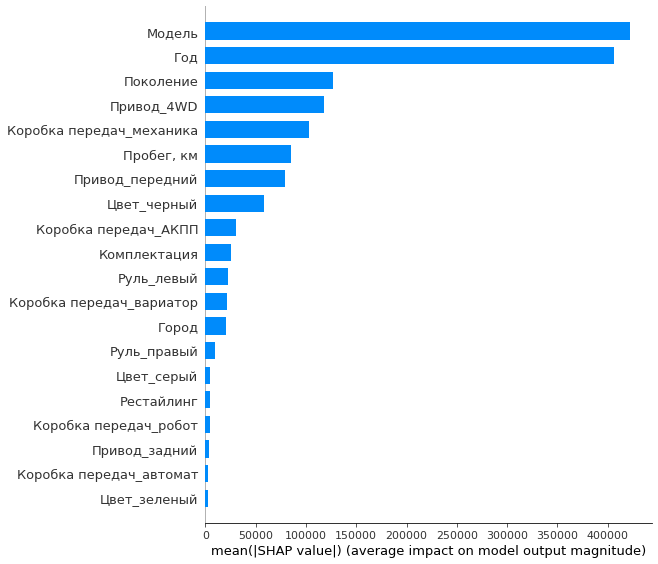

In [64]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

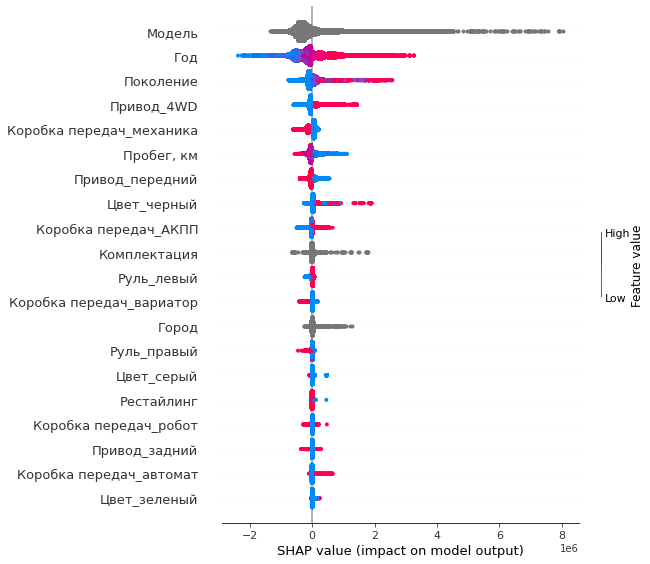

In [65]:
shap.summary_plot(shap_values, X_train)